# Top

https://www.geeksforgeeks.org/right-and-left-hand-detection-using-python/

https://google.github.io/mediapipe/getting_started/python.html

In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import myrepo.logging as mylog
from pathlib import Path
from datetime import datetime
import torch

# torch.set_default_tensor_type('torch.FloatTensor')

repo_list = []
# repo_list = [f"/home/hjchris/repo/FCN-pytorch",
# #              f"/home/hjchris/research/adv_mask/myrepo",
#              f"/home/hjchris/repo/pytorch-segmentation",
#              f"/home/hjchris/repo/pytorch-ssd-master",
#             ]

# for repo in repo_list: sys.path.append(repo) if not any(x == repo for x in sys.path) else None
today = datetime.now().strftime("%m%d_%y")    
# mylog.mylogger(root=Path.cwd() / 'logs'/ 'MP', force=False)
# train_log = mylog.mylog

# Preprocessing

## Save vids as frames

In [3]:
import cv2
from pathlib import Path

def save_frames(video_root, video_name):
    invalid_frames = []
    video_path = video_root / f"{video_name}"
    print(f"Video Path: {video_path}")
    save_path = (Path.cwd() / 'frames' / video_name)
    print(f"Save Path: {save_path}")
    vidcap = cv2.VideoCapture(str(video_path))
    
    success,image = vidcap.read()
    count = 0
    save_path.mkdir(parents=True, exist_ok=True)
    while success:
        cv2.imwrite(str(save_path)+f"/frame{str(count).zfill(5)}.jpg", image)   # save frame as JPEG file      
        success, image = vidcap.read()
        if not success: invalid_frames.append(f"frame{str(count).zfill(5)}.jpg")
        #print(f'Read a new frame: {count}', success)
        count += 1
    print(f"Total number of frames:{count}")
    print(f"Invalid frames: {invalid_frames}")

    
VIDEO_NAME = 'front_close_hands_converted.mp4'
VIDEO_NAME = 'PXL_01.mp4'
VIDEO_NAME = f'diag_close_hand_2.mp4'
VIDEO_NAME = f'diag_close_hand.mp4'
VIDEO_NAME = f'admin.mp4'
VIDEO_NAME = f'hands3.mp4'
VIDEO_NAME = f'kb_loc2.mp4'
VIDEO_NAME = f'upper_angle_kb.mp4'
VIDEO_NAME = f'semiconductor_upper_angle.mp4'
VIDEO_NAME = f'semiconductor_0130.mp4'
# VIDEO_NAME = f'semiconductor_angle2.mp4'
# VIDEO_NAME = 'password'
VIDEO_ROOT = Path('/home/ssysarch/Documents/vr/vr_test_videos/')
# VIDEO_ROOT = Path('/home/hjchris/research/22vr-kl/videos/')
# save_frames(VIDEO_ROOT, VIDEO_NAME)

## Read File

In [4]:
finger_maps = {0:"WRIST", 1:"THUMB_CMC", 2:"THUMB_MCP",3:"THUMB_IP", 4:"THUMB_TIP", 5:"INDEX_FINGER_MCP",
               6:"INDEX_FINGER_PIP", 7:"INDEX_FINGER_DIP", 8:"INDEX_FINGER_TIP", 9:"MIDDLE_FINGER_MCP", 10:"MIDDLE_FINGER_PIP",
               11:"MIDDLE_FINGER_DIP", 12:"MIDDLE_FINGER_TIP", 13:"RING_FINGER_MCP", 14:"RING_FINGER_PIP", 15:"RING_FINGER_DIP",
               16:"RING_FINGER_TIP", 17:"PINKY_MCP", 18:"PINKY_PIP", 19:"PINKY_DIP", 20:"PINKY_TIP",}

Read /home/hjchris/research/22vr-kl/frames/semiconductor_0130.mp4


100%|██████████| 3338/3338 [01:03<00:00, 52.68it/s]


3338 frames.


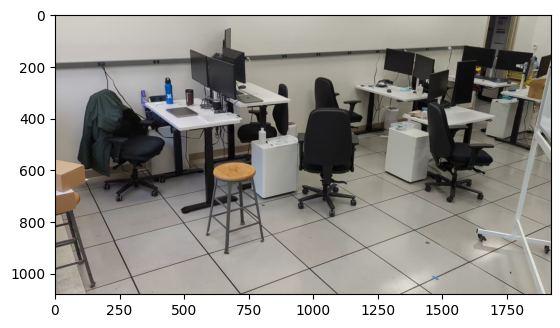

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

def read_frames(frame_path):
    frame_path.mkdir(parents=True, exist_ok=True)
    frame_names = sorted(os.listdir(frame_path))
    frames      = []
    print(f"Read {frame_path}")
    for i, name in enumerate(tqdm(frame_names)):
        if '.jpg' in name:
            frame = cv2.imread(f'{frame_path/name}')
            height, width, _ = frame.shape
            frames.append([name, frame])
    print(f"{len(frames)} frames.")
    plt.imshow(cv2.cvtColor(frames[0][1], cv2.COLOR_BGR2RGB))
    plt.show()
    return frames   


FRAME_FOLDER = f'PXL_01'
FRAME_FOLDER = f'IMG_1817'
# FRAME_FOLDER = f'IMG_1820'
# FRAME_FOLDER = f'IMG_1816'
FRAME_FOLDER = f'password'
# FRAME_FOLDER = f'diag_close_hand_2.mp4'
# FRAME_FOLDER = f'admin.mp4'
FRAME_FOLDER = f'hands3.mp4'
FRAME_FOLDER = f'kb_loc.mp4'
FRAME_FOLDER = f'kb_loc2.mp4'
FRAME_FOLDER = f'upper_angle_kb.mp4'
FRAME_FOLDER = f'semiconductor_upper_angle.mp4'
FRAME_FOLDER = f'semiconductor_0130.mp4'
# FRAME_FOLDER = f'semiconductor_angle2.mp4'
FRAME_PATH = Path(f'/home/hjchris/research/22vr-kl/frames/{FRAME_FOLDER}')

frames = read_frames(FRAME_PATH)

# Mediapipe Body and Hand Tracking

## Helper functions

In [7]:
def body_direction(landmarks):
    # 
    first_index, second_index = 12, 24
    x = landmarks[first_index].x - landmarks[second_index].x
    y = landmarks[first_index].y - landmarks[second_index].y
    z = landmarks[first_index].z - landmarks[second_index].z
    first_vector = np.array([x,y,z])
#     first_vector /= np.linalg.norm(first_vector)
    
    first_index, second_index = 11, 23
    x = landmarks[first_index].x - landmarks[second_index].x
    y = landmarks[first_index].y - landmarks[second_index].y
    z = landmarks[first_index].z - landmarks[second_index].z
    second_vector = np.array([x,y,z])
#     second_vector /= np.linalg.norm(second_vector)

    # outer product
    final_vector = -np.cross(first_vector, second_vector)
    final_vector /= np.linalg.norm(final_vector)
    return final_vector

def body_direction2(landmarks, first_index=19, second_index=11):
    x = landmarks[first_index].x - landmarks[second_index].x
    y = landmarks[first_index].y - landmarks[second_index].y
    z = landmarks[first_index].z - landmarks[second_index].z
    return np.array([x,y,z])


def draw_direction(annotated_image, image_width, image_height, facing_vectors, landmarks, idx1, idx2):
    '''
    Draw pinch direction by selected idx.
    '''

#     start_pt = (np.array([(landmarks[idx1].x+landmarks[idx2].x)*image_width, (landmarks[idx1].y+landmarks[idx2].y)*image_height])/2)
#     end_pt   = start_pt + 5000*np.average(facing_vectors, 0)[:-1]
#     print(facing_vectors[-1][:-1])
    start_pt   = np.array([landmarks[idx1].x*image_width, landmarks[idx1].y*image_height])
    end_pt   = np.array([landmarks[idx2].x*image_width, landmarks[idx2].y*image_height])

    # draw
    cv2.line(annotated_image, start_pt.astype(int), end_pt.astype(int), (20, 255, 0), 3)
    
    print('end point:', end_pt)

def draw_direction2(annotated_image, image_width, image_height, facing_vectors, landmarks, idx1=12, idx2=16):
    '''
    manually approximate the fingertips to define the position.
    '''
    
    # starting point
    finger_pt = np.array([(2*landmarks[20].x-landmarks[16].x)*image_width, (2*landmarks[20].y-landmarks[16].y)*image_height])
    finger_pt[0] += 20
    finger_pt[1] += 20
    
    # vector (from shoulder to finger tip)
    shoulder_pt  = np.array([landmarks[12].x*image_width,   landmarks[12].y*image_height])
    pinch_vector = np.array([(finger_pt[0]-shoulder_pt[0]), (finger_pt[1]-shoulder_pt[1])])
    
    # end point
    end_pt   = finger_pt + pinch_vector*500
    
    # draw
    cv2.line(annotated_image, finger_pt.astype(int), end_pt.astype(int), (0, 255, 0), thickness=3)
    
def draw_direction3(annotated_image, image_width, image_height, facing_vectors, landmarks, hands_landmarks, idx1=12, idx2=16):
    '''
    using hand tracking to capture the finger position.
    '''
    for hand_landmarks in hands_landmarks:
        
        # starting point
        finger_pt = np.array([(hand_landmarks.landmark[4].x+hand_landmarks.landmark[8].x)*image_width/2, 
                              (hand_landmarks.landmark[4].y+hand_landmarks.landmark[8].y)*image_height/2])
        shoulder_pt  = np.array([landmarks[12].x*image_width,   landmarks[12].y*image_height])
        
        # vector (from shoulder to finger tip)
        pinch_vector = np.array([(finger_pt[0]-shoulder_pt[0]), (finger_pt[1]-shoulder_pt[1])])

        # end point = starting point + vector
        end_pt   = finger_pt + pinch_vector*500

        # draw
        cv2.line(annotated_image, finger_pt.astype(int), end_pt.astype(int), (255, 0, 0), thickness=5)
    
    
def keyboard_center(annotated_image, image_width, image_height, landmarks, idx1=12, idx2=16):
    '''
    keyboard center approximation using outer products of body results from body tracking.
    '''
    # obtain points
    shoulder_center = np.array([(landmarks[12].x + landmarks[11].x)/2, 
                                (landmarks[12].y + landmarks[11].y)/2,
                                (landmarks[12].z + landmarks[11].z)/2])
    butt_center     = np.array([(landmarks[24].x + landmarks[23].x)/2, 
                               (landmarks[24].y + landmarks[23].y)/2,
                               (landmarks[24].z + landmarks[23].z)/2])
    
    # obtain the two vectors 
    first_vector    = np.array([(landmarks[24].x - landmarks[23].x), 
                              (landmarks[24].y - landmarks[23].y),
                              (landmarks[24].z - landmarks[23].z)])
    second_vector = shoulder_center - butt_center
    
    # normalized outer product
    drawing_vector = -np.cross(first_vector, second_vector)
    drawing_vector /= np.linalg.norm(drawing_vector)
    drawing_vector *= 20
    
    # draw lines
    line_nums = 15
    for i in range(line_nums):
#         shoulder_center += drawing_vector
#         butt_center     += drawing_vector
        start_point = np.array([shoulder_center[0]*image_width  + drawing_vector[0]*i,  
                                shoulder_center[1]*image_height + drawing_vector[1]*i])
        end_point   = np.array([butt_center[0]*image_width  + drawing_vector[0]*i, 
                                butt_center[1]*image_height + drawing_vector[1]*i])
        cv2.line(annotated_image, start_point.astype(int), end_point.astype(int), (0, 0, 255), thickness=3)

def keyboard_center2(annotated_image, image_width, image_height, landmarks, idx1=12, idx2=16):
    '''
    keyboard cetner using outer products of face results from body tracking.
    '''
    # obtain the points
    shoulder_center = np.array([(landmarks[12].x + landmarks[11].x)/2, 
                                (landmarks[12].y + landmarks[11].y)/2, 
                                (landmarks[12].z + landmarks[11].z)/2])
    eyes_center = np.array([(landmarks[4].x + landmarks[1].x)/2, 
                            (landmarks[4].y + landmarks[1].y)/2, 
                            (landmarks[4].z + landmarks[1].z)/2])
    nose_center = np.array([landmarks[0].x, landmarks[0].y, landmarks[0].z])
    
    # obtain the two vectors 
    first_vector = np.array([(landmarks[4].x - landmarks[1].x)/2, (landmarks[4].y - landmarks[1].y)/2, (landmarks[4].z - landmarks[1].z)/2])
    second_vector = eyes_center - nose_center
    second_vector /= np.linalg.norm(second_vector)
    
    # normalized outer product of the two vectors
    drawing_vector = -np.cross(first_vector, second_vector)
    drawing_vector /= np.linalg.norm(drawing_vector)
    drawing_vector *= 20
    
    # draw lines
    line_nums = 10
    for i in range(line_nums):
#         shoulder_center += drawing_vector
#         butt_center     += drawing_vector
        start_point = np.array([shoulder_center[0]*image_width  + drawing_vector[0]*i, shoulder_center[1]*image_height + drawing_vector[1]*i])
        end_point   = np.array([start_point[0] - second_vector[0]*200, start_point[1] - second_vector[1]*200])
        cv2.line(annotated_image, start_point.astype(int), end_point.astype(int), (0, 20, 255), thickness=3) 

def keyboard_range(annotated_image, image_width, image_height, landmarks, dir_dic):
    '''
    Draw the real position of the virtual keyboard.
    '''
    # corner coords
    bottom_right = dir_dic[0]
    bottom_left  = dir_dic[1]
    top_right    = dir_dic[2]
    top_left     = dir_dic[3]
    
    # draw lines
    cv2.line(annotated_image, bottom_right.astype(int), bottom_left.astype(int), (0, 120, 255), thickness=2) 
    cv2.line(annotated_image, bottom_right.astype(int), top_right.astype(int), (0, 120, 255), thickness=2) 
    cv2.line(annotated_image, top_left.astype(int),     top_right.astype(int), (0, 120, 255), thickness=2) 
    cv2.line(annotated_image, top_left.astype(int),     bottom_left.astype(int), (0, 120, 255), thickness=2) 
    
    # draw middle line
    bottom_middle = (bottom_right + bottom_left) / 2
    top_middle = (top_right + top_left) / 2
    cv2.line(annotated_image, bottom_middle.astype(int), top_middle.astype(int), (0, 120, 255), thickness=2)   
    
    finger_pt = np.array([(2*landmarks[20].x-landmarks[16].x)*image_width, (2*landmarks[20].y-landmarks[16].y)*image_height])
    print(finger_pt)
    
    
def handmv_range(annotated_image, image_width, image_height, landmarks, dir_dic):
    '''
    Draw the range of hand movements when typing the virtual keyboard.
    '''
    # corner coords
    bottom_right = dir_dic[4]
    bottom_left  = dir_dic[5]
    top_right    = dir_dic[6]
    top_left     = dir_dic[7]
    
    # draw 
    cv2.line(annotated_image, bottom_right.astype(int), bottom_left.astype(int), (0, 120, 255), thickness=2) 
    cv2.line(annotated_image, bottom_right.astype(int), top_right.astype(int), (0, 120, 255), thickness=2)
    cv2.line(annotated_image, top_left.astype(int),     top_right.astype(int), (0, 120, 255), thickness=2) 
    cv2.line(annotated_image, top_left.astype(int),     bottom_left.astype(int), (0, 120, 255), thickness=2) 
    
    # draw middle line
    bottom_middle = (bottom_right + bottom_left) / 2
    top_middle = (top_right + top_left) / 2
    cv2.line(annotated_image, bottom_middle.astype(int), top_middle.astype(int), (0, 120, 255), thickness=2) 
    
    finger_pt = np.array([(2*landmarks[20].x-landmarks[16].x)*image_width, (2*landmarks[20].y-landmarks[16].y)*image_height])
    print(finger_pt)
    
    
def virtual_direction(annotated_image, image_width, image_height, landmarks, dir_dic):
    '''
    Draw the straight lines of the corners. The direction is from the pinch and the key.
    '''
    
    # hand corners
    h_bottom_right  = dir_dic[4]
    h_bottom_left   = dir_dic[5]
    h_top_right     = dir_dic[6]
    h_top_left      = dir_dic[7]
    h_bottom_middle = (h_bottom_right + h_bottom_left) / 2
    h_top_middle    = (h_top_right + h_top_left) / 2
    
    # keyboard corners
    bottom_right = dir_dic[0]
    bottom_left  = dir_dic[1]
    top_right    = dir_dic[2]
    top_left     = dir_dic[3]
    bottom_middle = (bottom_right + bottom_left) / 2
    top_middle    = (top_right + top_left) / 2
    
    # calcuate directions
    br_direction = h_bottom_right - bottom_right
    bl_direction = h_bottom_left - bottom_left
    tr_direction = h_top_right - top_right
    tl_direction = h_top_left - top_left
    bm_direction = h_bottom_middle - bottom_middle
    tm_direction = h_top_middle - top_middle
    
    # draw
    cv2.line(annotated_image, bottom_right.astype(int), (bottom_right+br_direction*5).astype(int), (120, 120, 255), thickness=2) 
    cv2.line(annotated_image, bottom_left.astype(int),  (bottom_left+bl_direction*5).astype(int), (120, 120, 255), thickness=2) 
    cv2.line(annotated_image, top_right.astype(int),    (top_right+tr_direction*5).astype(int), (120, 120, 255), thickness=2) 
    cv2.line(annotated_image, top_left.astype(int),     (top_left+tl_direction*5).astype(int), (120, 120, 255), thickness=2) 
    
    # draw middle lines
    cv2.line(annotated_image, bottom_middle.astype(int), (bottom_middle+bm_direction*5).astype(int), (180, 120, 155), thickness=2) 
    cv2.line(annotated_image, top_middle.astype(int),    (top_middle+tm_direction*5).astype(int), (180, 120, 155), thickness=2) 
    
    
def calculate_angle(a,b,c):
    a = np.array(a)
    b = np.array(b)    
    c = np.array(c)    
    
    radians = np.arctan2(c[1]-b[1],c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180:
        angle = 360 - angle
    
    return angle


def draw_central_line(annotated_image):
    '''
    manually crafted cetner lines.
    '''
    central_lines = [
                    [[588.88897705, 241.16627026], [592.22275543, 446.51678467]],
                    [[604.59138125, 248.9387603], [607.92515963, 454.28927471]],
                    [[620.29378545, 256.71125034], [623.62756383, 462.06176475]],
                    [[635.99618965, 264.48374037], [639.32996804, 469.83425479]],
                    [[651.69859386, 272.25623041], [655.03237224, 477.60674483]],
                    [[667.40099806, 280.02872045], [670.73477644, 485.37923487]],
                    [[683.10340226, 287.80121049], [686.43718064, 493.1517249]],
                    [[698.80580646, 295.57370053], [702.13958484, 500.92421494]],
                    [[714.50821066, 303.34619057], [717.84198904, 508.69670498]],
                    [[730.21061486, 311.11868061], [733.54439324, 516.46919502]],
                    [[745.91301906, 318.89117065], [749.24679744, 524.24168506]],
                    [[761.61542326, 326.66366069], [764.94920164, 532.0141751]],
                    [[777.31782746, 334.43615073], [780.65160585, 539.78666514]],
                    [[793.02023167, 342.20864077], [796.35401005, 547.55915518]],
                    [[808.72263587, 349.98113081], [812.05641425, 555.33164522]],
                    [[824.42504007, 357.75362085], [827.75881845, 563.10413526]],
                    [[840.12744427, 365.52611089], [843.46122265, 570.8766253]],
                    [[855.82984847, 373.29860093], [859.16362685, 578.64911534]],
                    [[871.53225267, 381.07109097], [874.86603105, 586.42160538]],
                    [[887.23465687, 388.84358101], [890.56843525, 594.19409542]],
                    [[902.93706107, 396.61607105], [906.27083946, 601.96658546]],
                    [[918.63946528, 404.38856109], [921.97324366, 609.7390755]],
                    [[934.34186948, 412.16105112], [937.67564786, 617.51156554]],
                    [[950.04427368, 419.93354116], [953.37805206, 625.28405558]],
                    [[965.74667788, 427.7060312], [969.08045626, 633.05654562]],
                    [[981.44908208, 435.47852124], [984.78286046, 640.82903566]],
                    [[997.15148628, 443.25101128], [1000.48526466, 648.60152569]],
                    [[1012.85389048, 451.02350132], [1016.18766886, 656.37401573]],
                    [[1028.55629468, 458.79599136], [1031.89007306, 664.14650577]],
                    [[1044.25869888, 466.5684814], [1047.59247727, 671.91899581]],
                    ]
    for i in range(len(central_lines)):
        start_point = np.array(central_lines[i][0])
        end_point   = np.array(central_lines[i][1])
        cv2.line(annotated_image, start_point.astype(int), end_point.astype(int), (0, 0, 255), thickness=1)

## Hyperparameters

In [10]:
''' 
hard coding the coordinates.

0 = bottom_right, 1 = bottom_left, 2 = top_right, 3 = top_left,
4 = h_bottom_right, 5 = h_bottom_left, 6 = h_top_right, 7 = h_top_left (hand_top_left)
'''

DIR_DIC = {
    'semiconductor_0130.mp4':{
        0: np.array([624.74057007, 476.56034088]),
        1: np.array([824.01342773, 454.63447952]),
        2: np.array([650, 430.89647865]),
        3: np.array([857.43875122, 407.57595634]),
        4: np.array([592.12294006, 350.99669838]),
        5: np.array([654.56529236, 328.22493172]),
        6: np.array([585.10978699, 320.58621407]),
        7: np.array([653.14759827, 310.73198414]),
#         's':np.array(),
#         'e':np.array(),
#         'm':np.array(),
#         'i':np.array(),
#         'c':np.array(),
#         'o':np.array(),
#         'n':np.array(),
#         'd':np.array(),
#         'u':np.array(),
#         'c':np.array(),
#         't':np.array(),
#         'o':np.array(),
#         'r':np.array(),
    },
                }


SELECTED_FRAMES = [2712, 2740, 2777, 2802, 2839, 2867, 2894, 2931, 2958, 2994, 3021, 3065, 3127]  #semiconductor
# SELECTED_FRAMES = [456, 610, 669, 707, 771] # keyboard 4 corners
# SELECTED_FRAMES = [1670, 1538, 1573, 1623]  # hand movement 4 corners
# SELECTED_FRAMES = [1933, 1968, 2018, 2065, 2114, 2161, 2200, 2244, 2303, 2345, 2388, 2435, 2483]  #semiconductor ground truth
# SELECTED_FRAMES = []

## Run

  0%|          | 0/3338 [00:00<?, ?it/s]

1080 1920


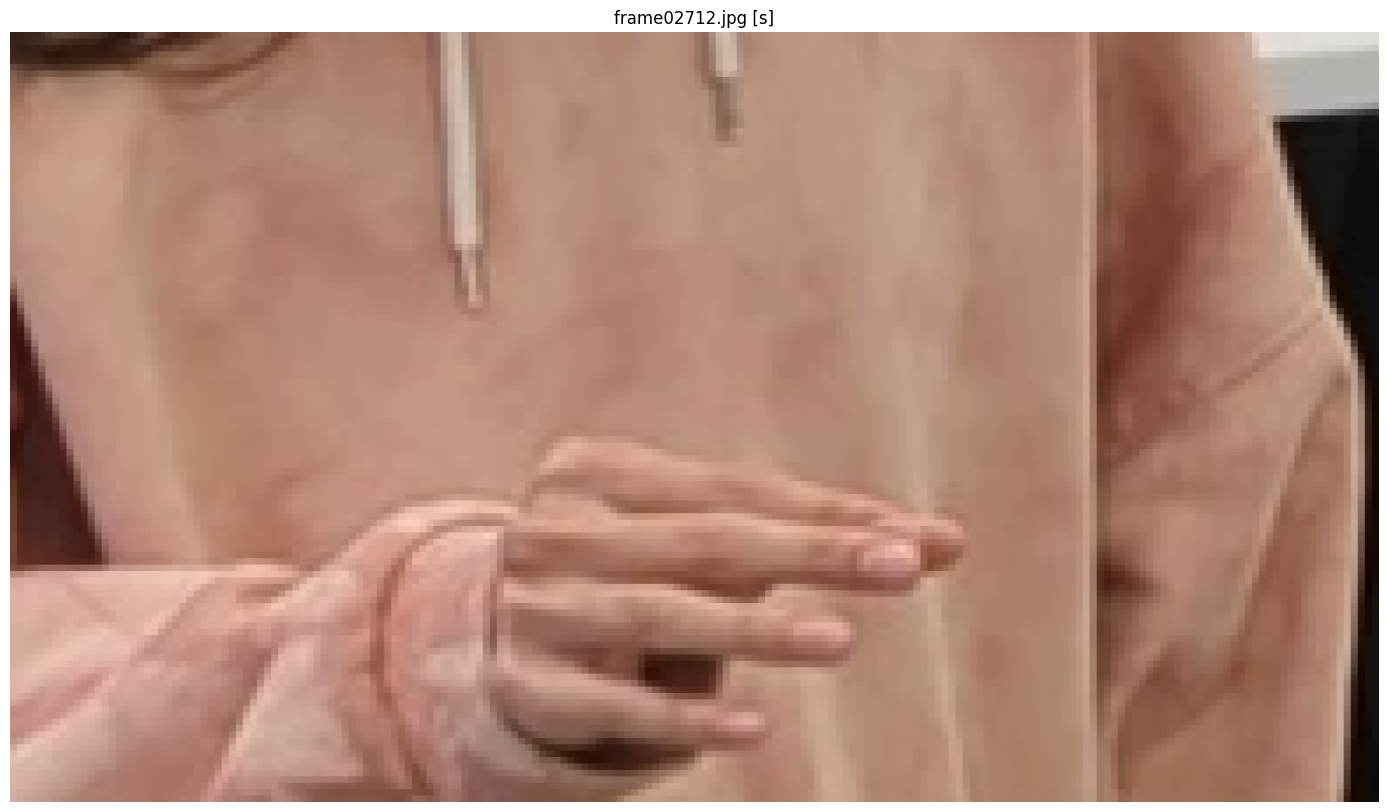

 81%|████████▏ | 2713/3338 [00:00<00:00, 4667.38it/s]

1080 1920


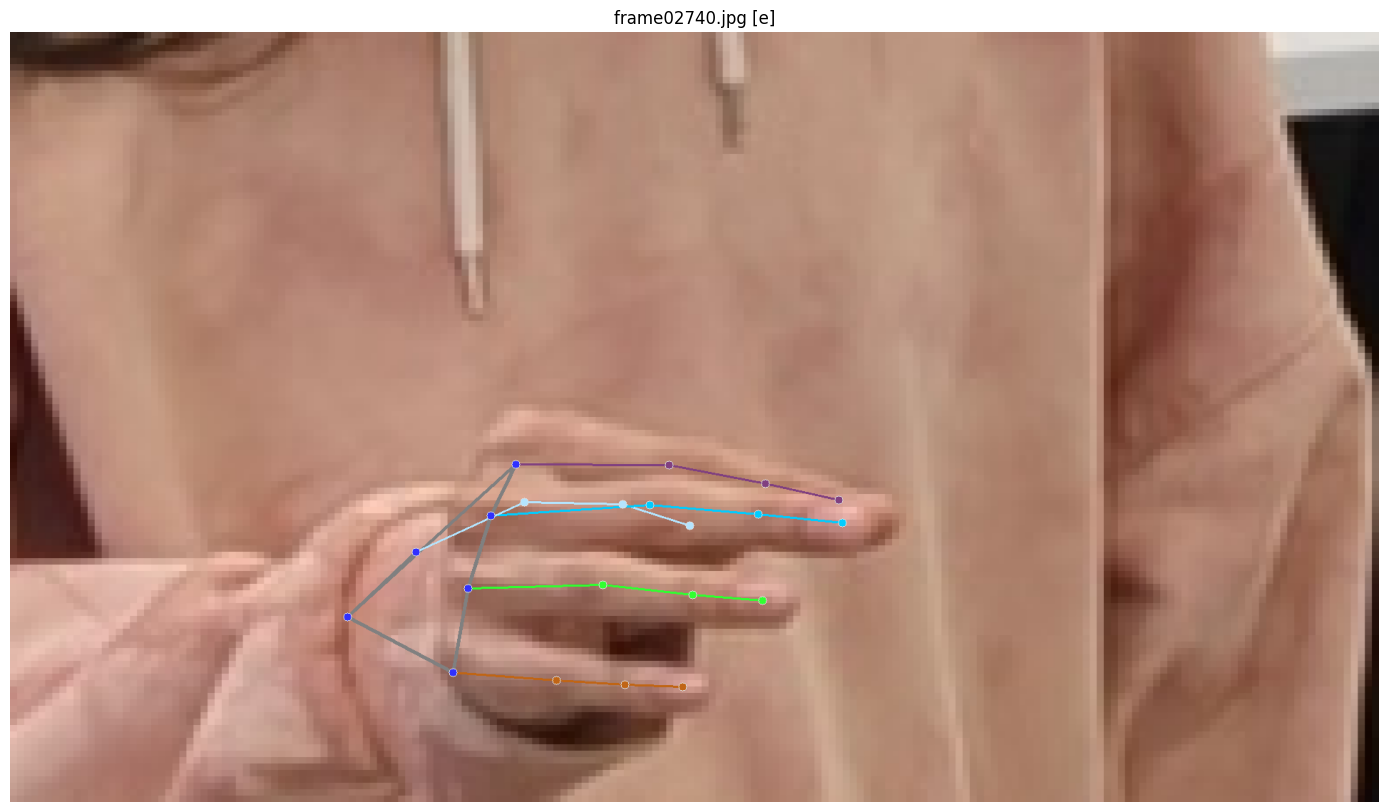

1080 1920


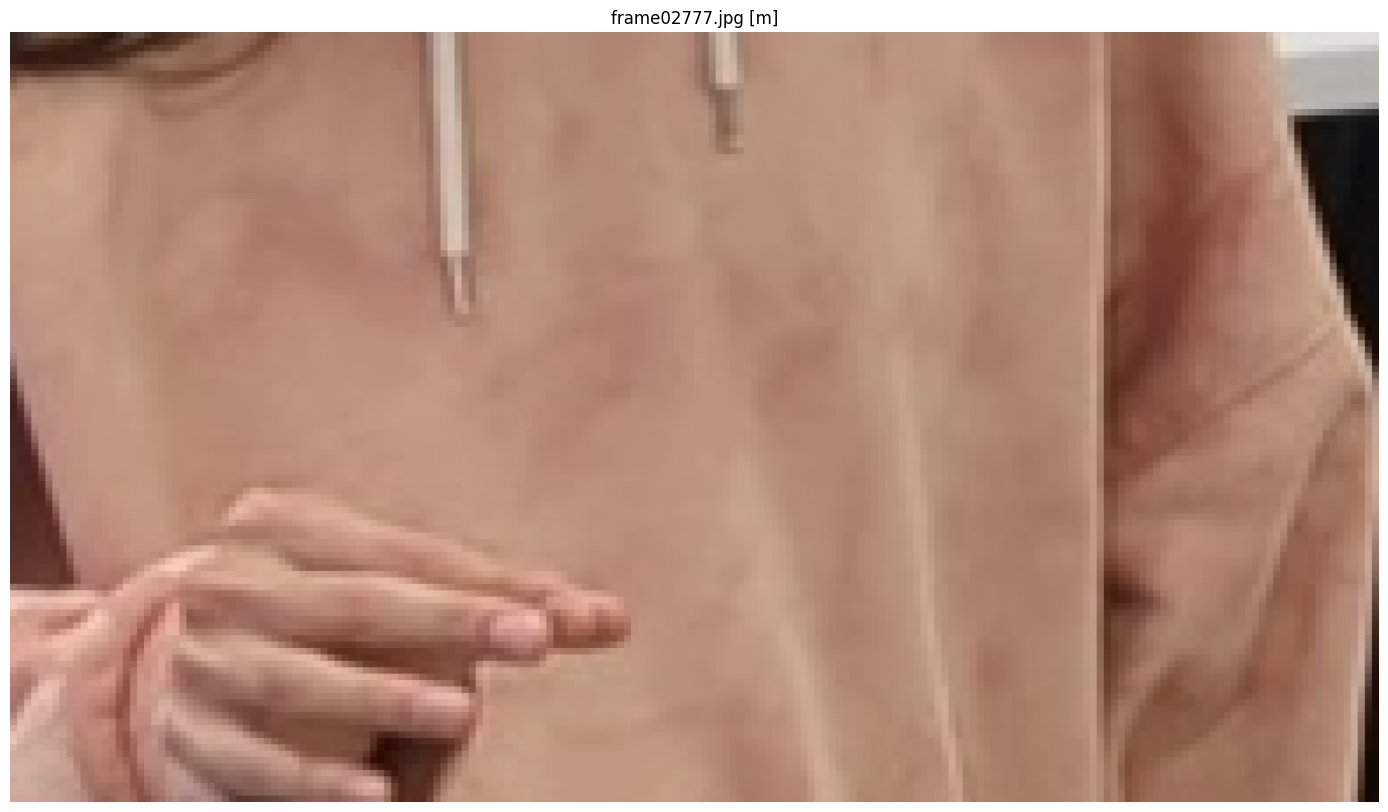

1080 1920


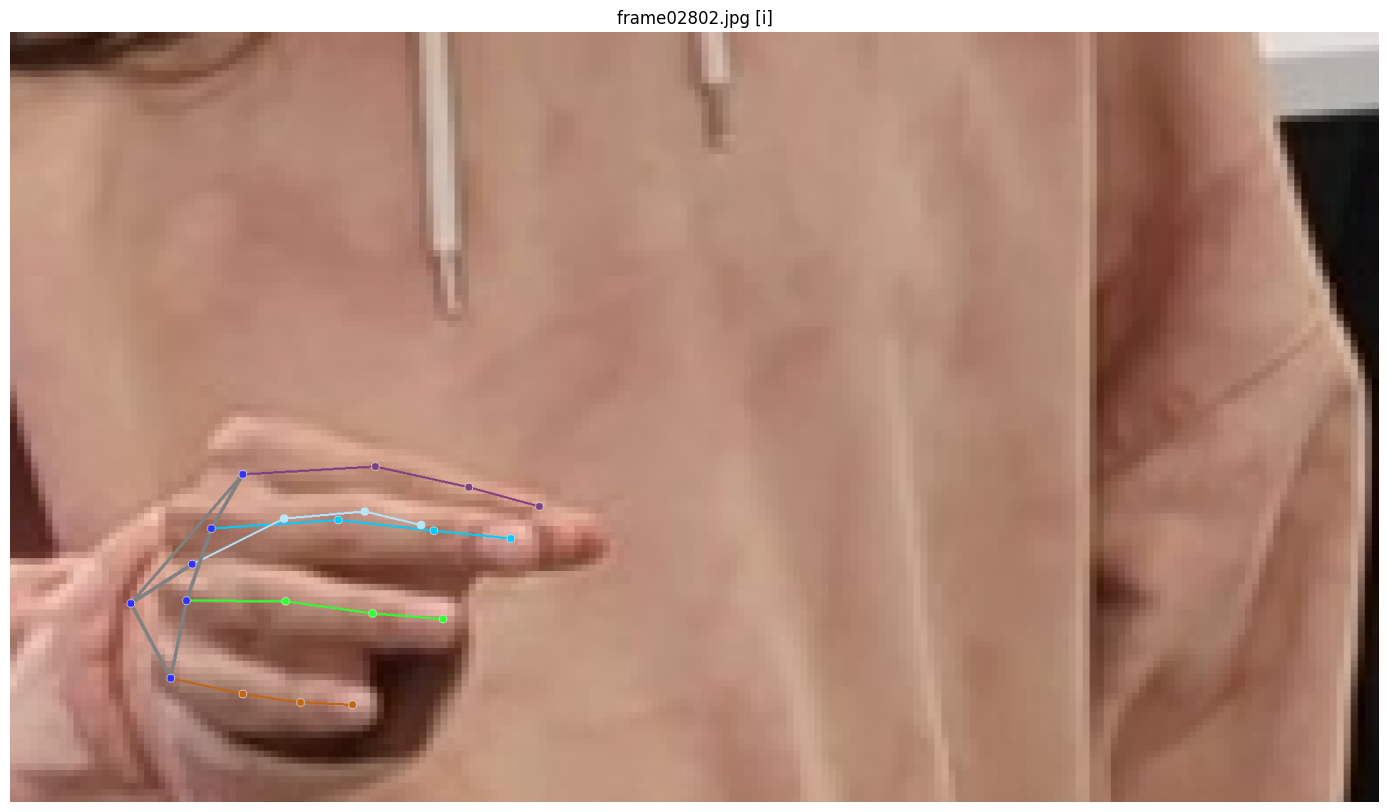

1080 1920


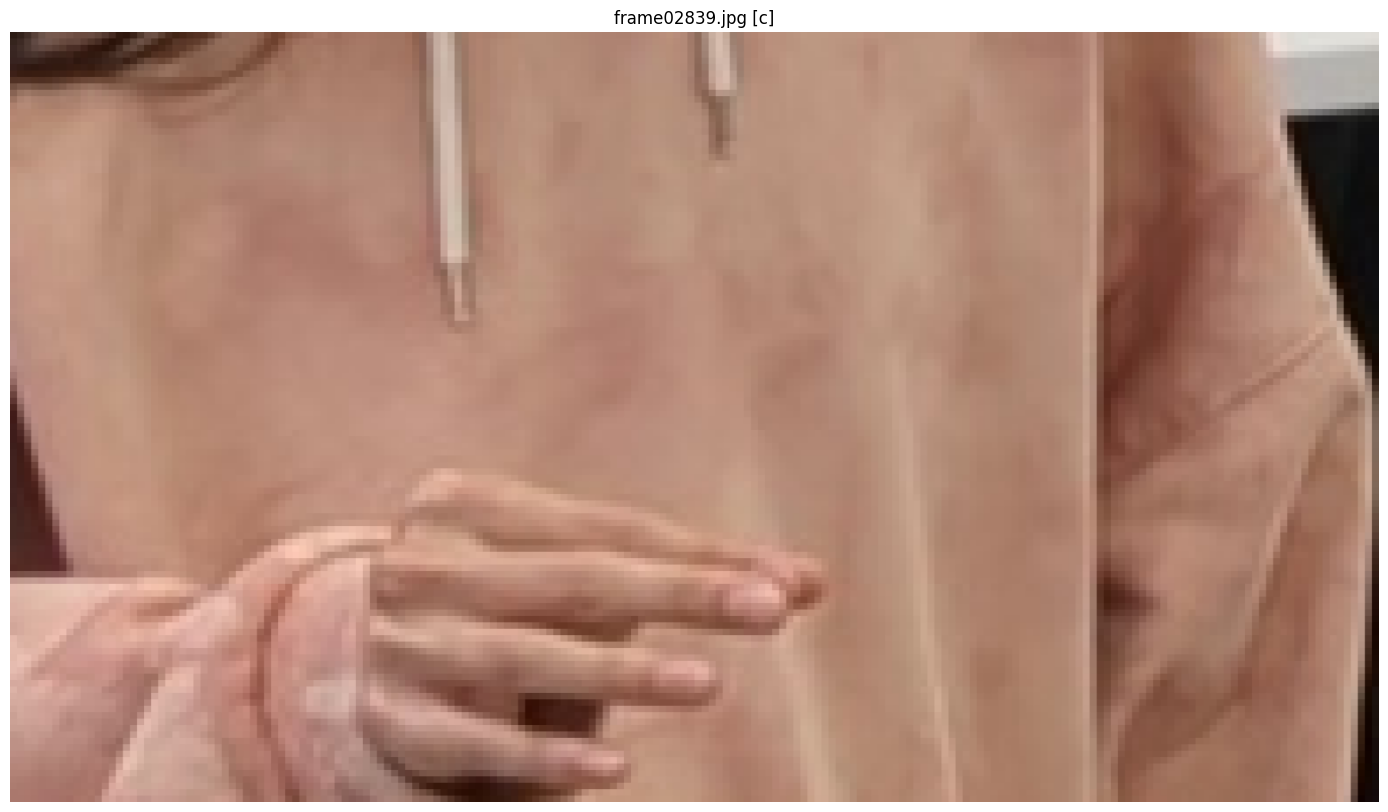

1080 1920


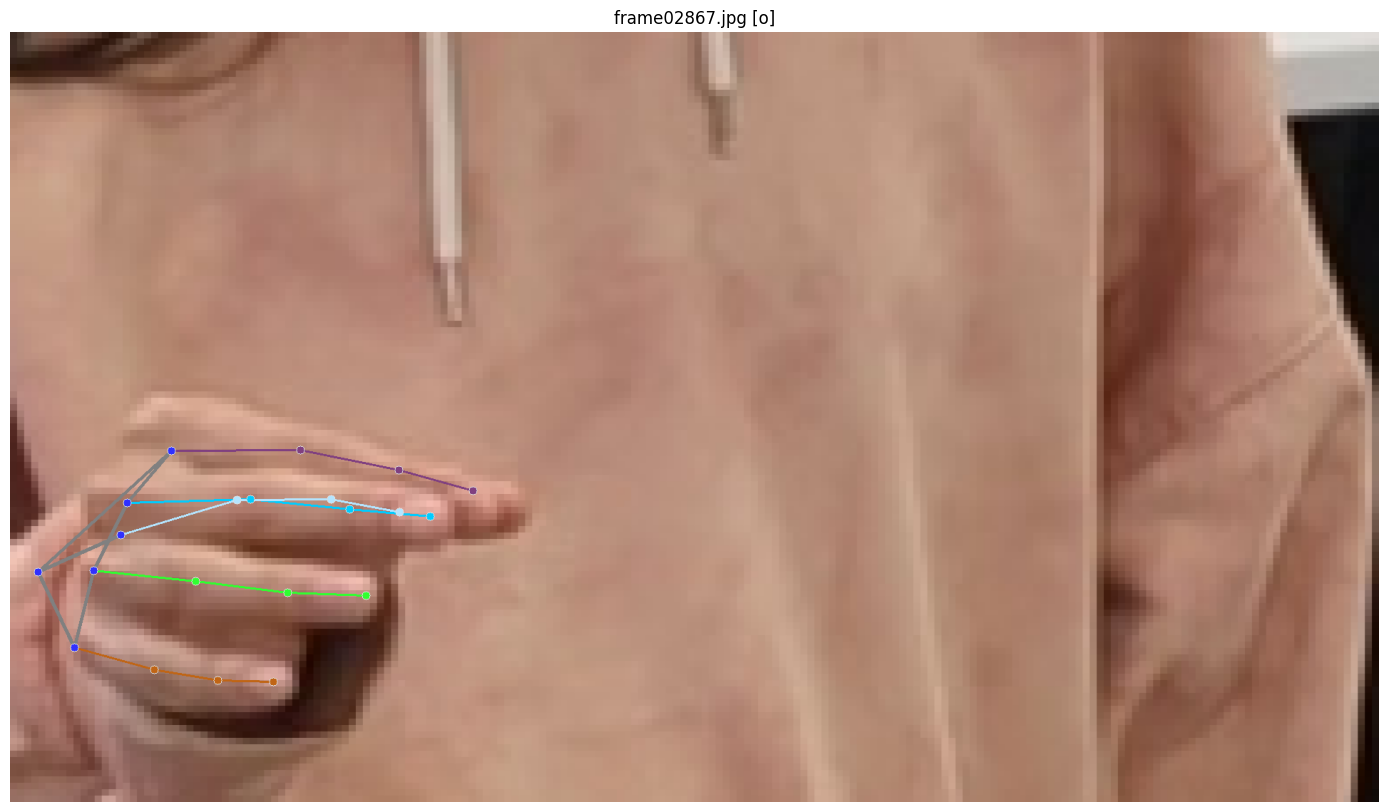

1080 1920


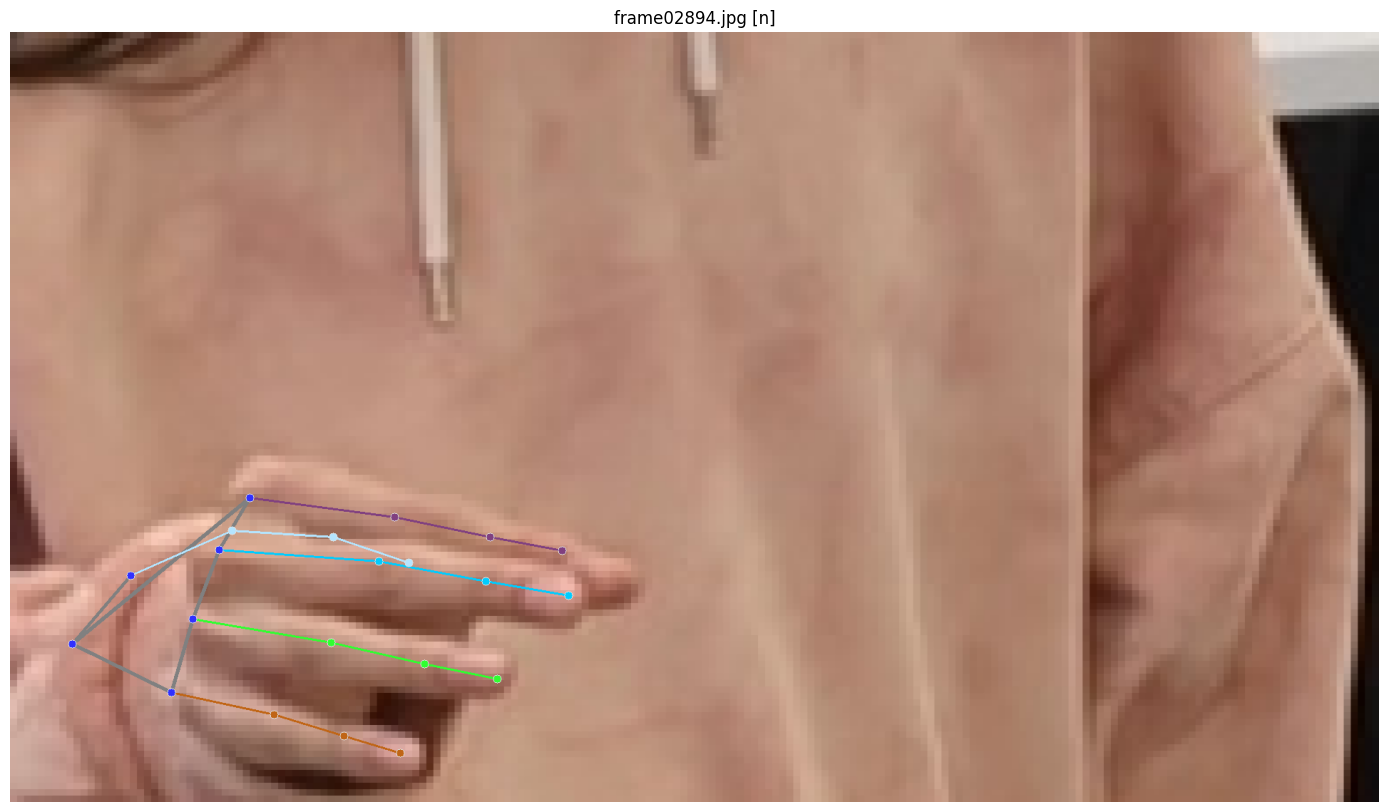

1080 1920


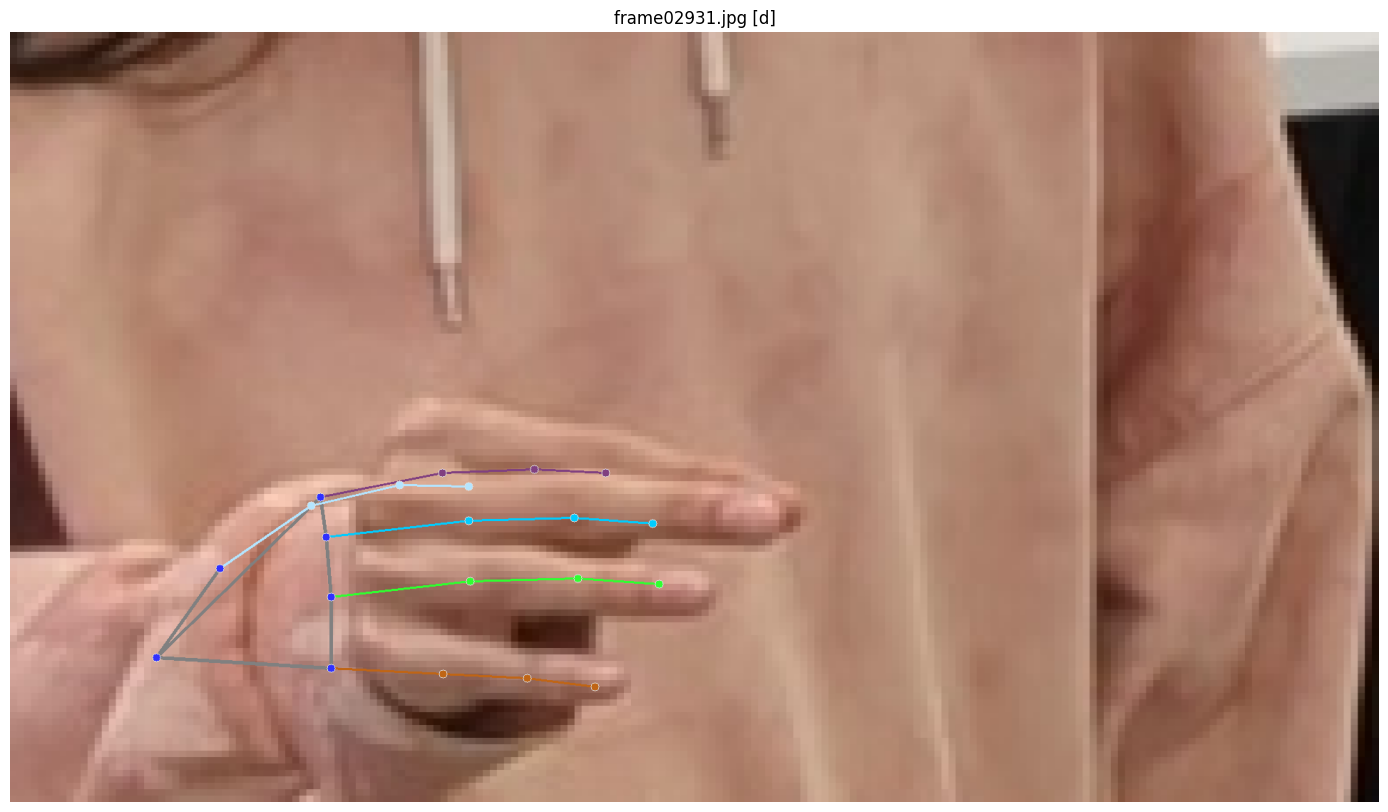

1080 1920


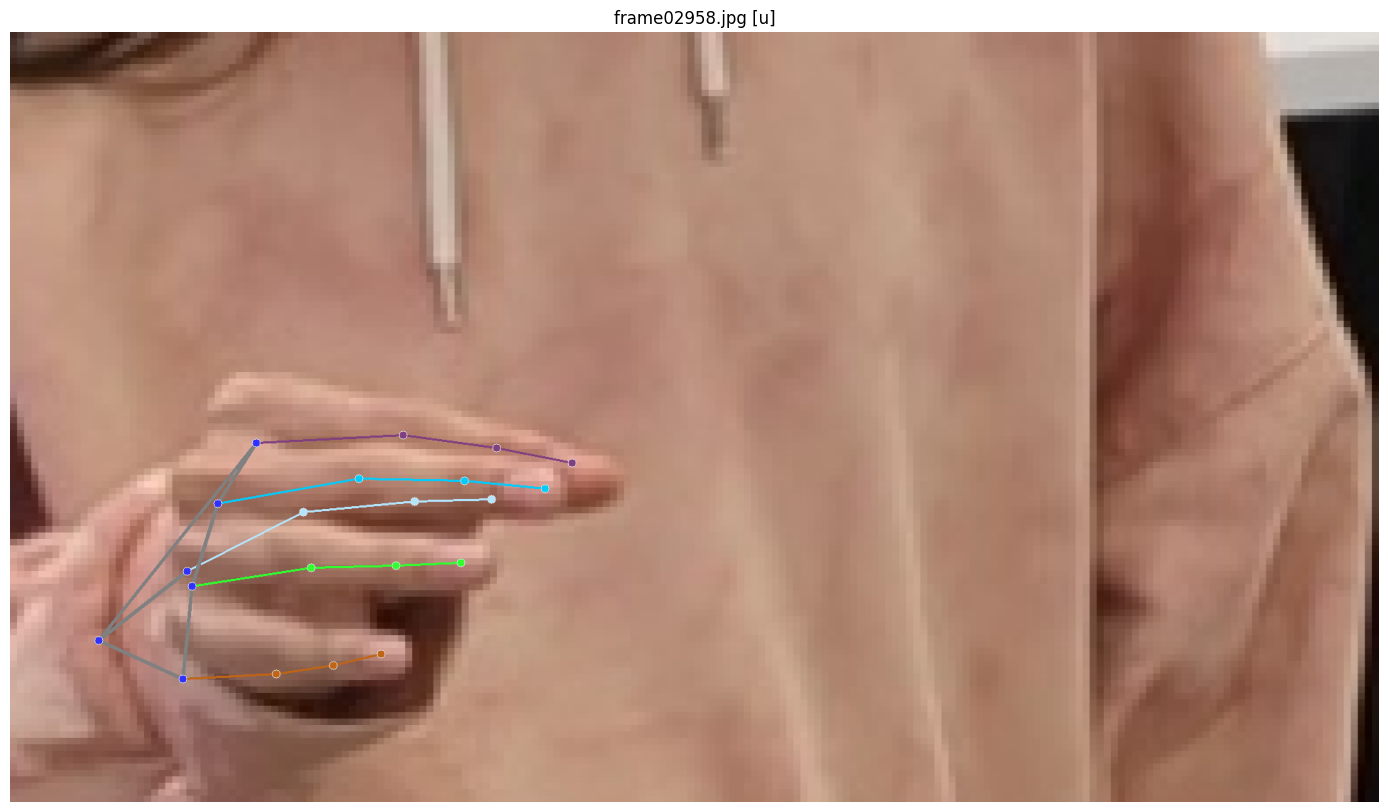

1080 1920


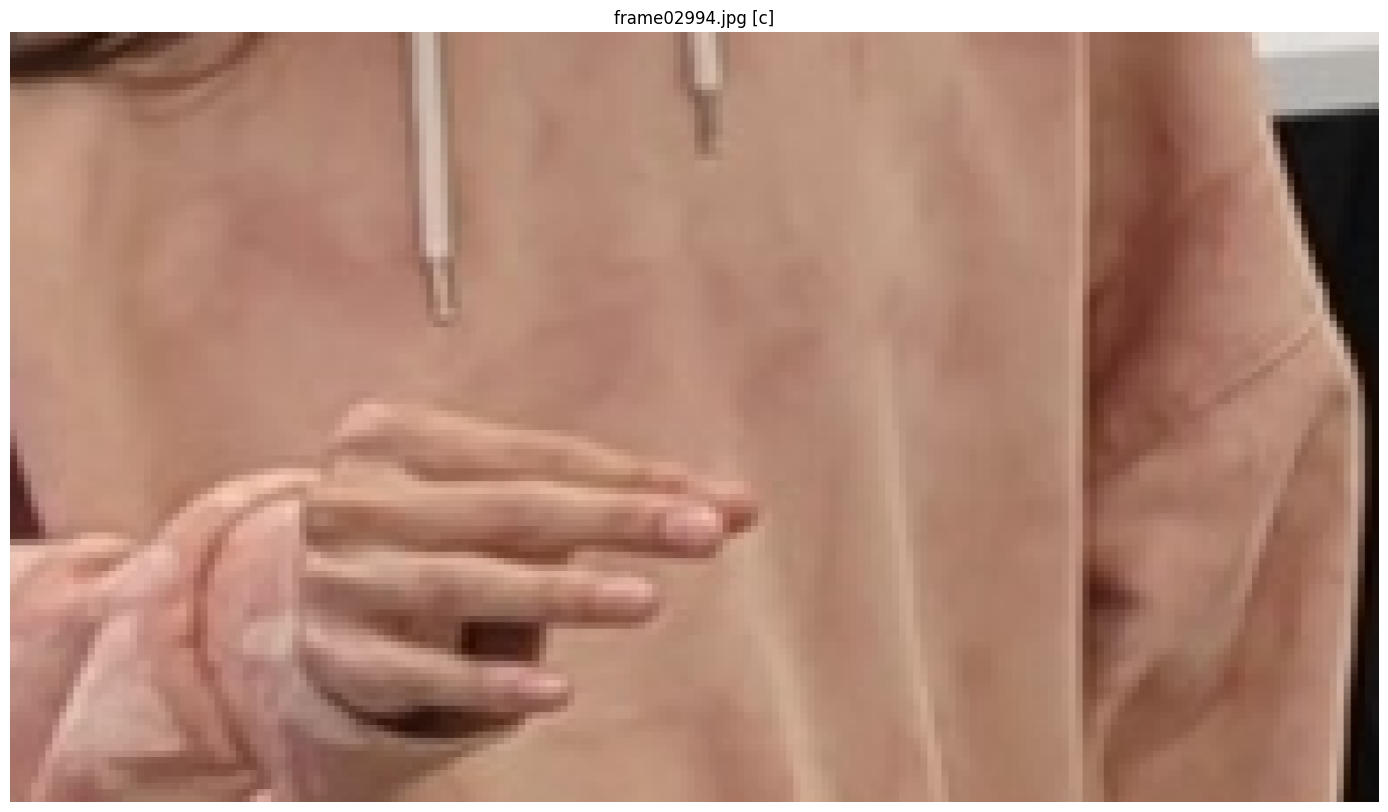

1080 1920


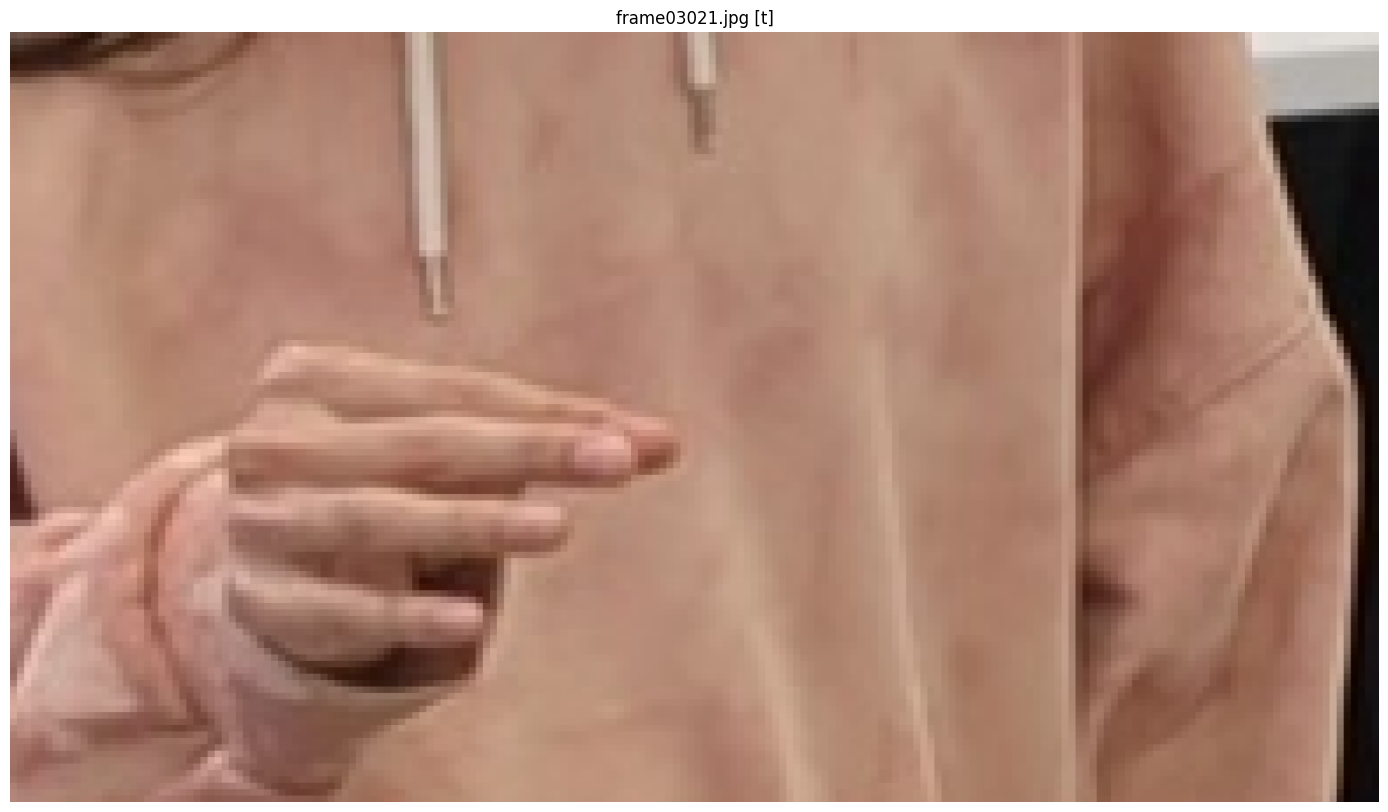

1080 1920


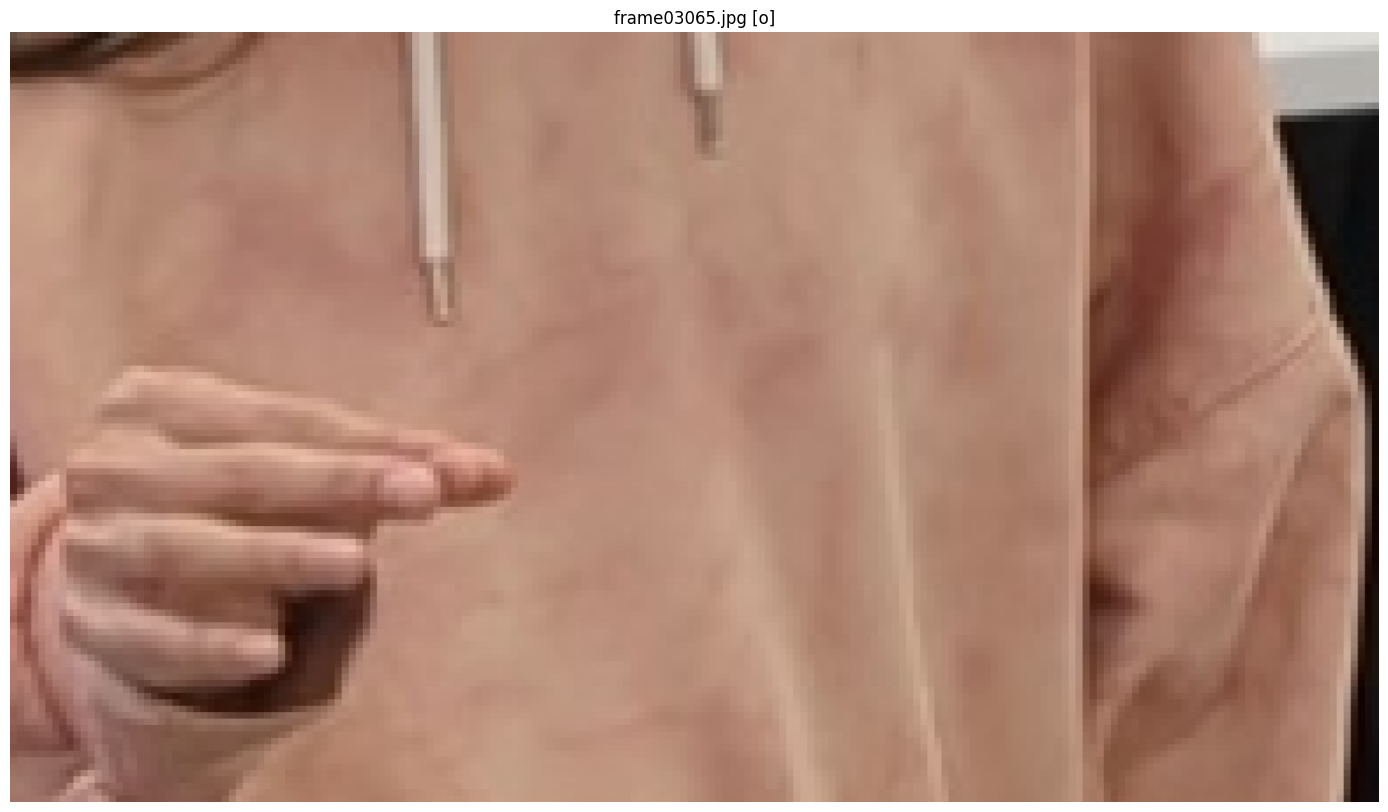

1080 1920


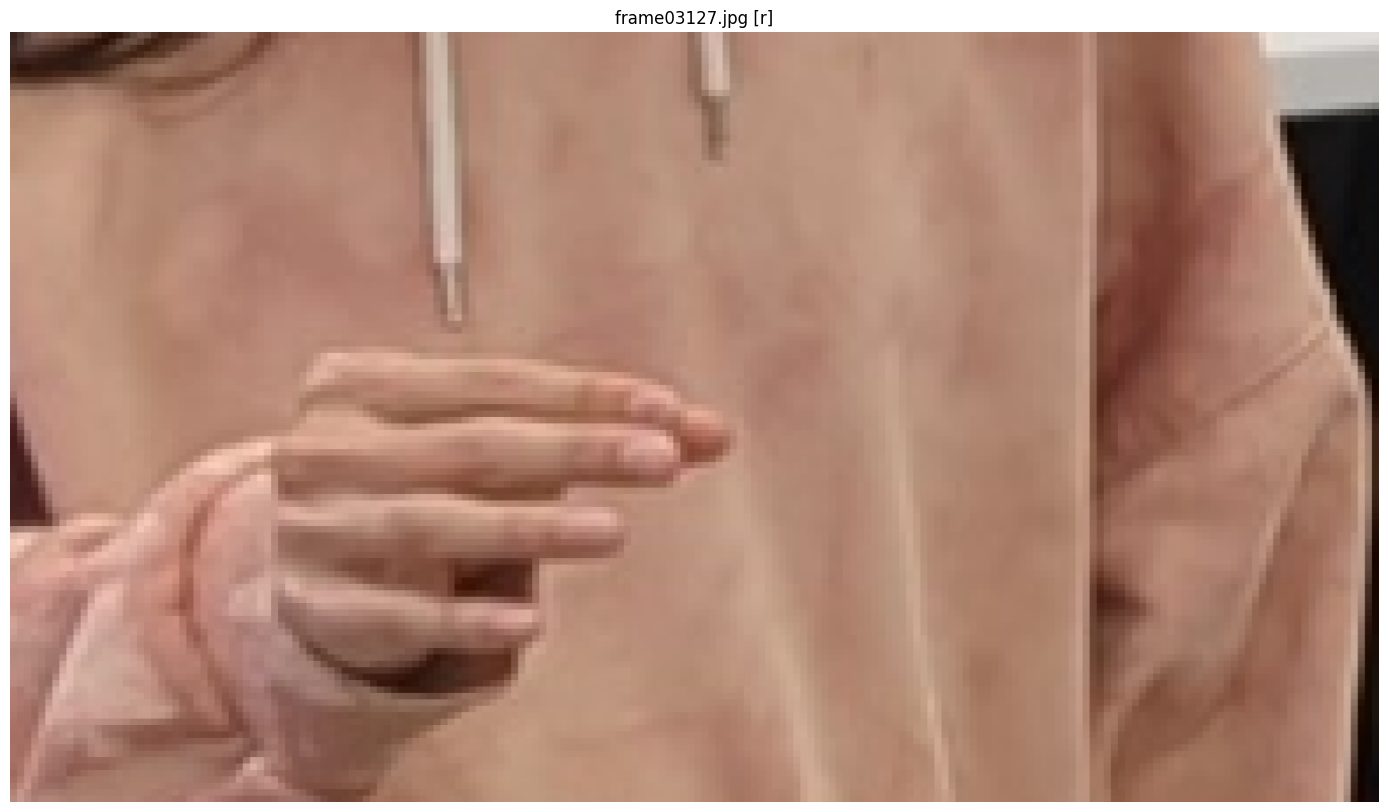

100%|██████████| 3338/3338 [00:05<00:00, 628.66it/s] 

['frame02994.jpg', 'frame03021.jpg', 'frame03065.jpg', 'frame03127.jpg']
[ 0.15216176 -0.08390361 -0.52124895]
[-0.20210496 -0.04023218 -0.16064867]
[-0.09346752 -0.03531694 -0.3943606 ]
[ 0.12006074 -0.09664208  0.00771616]
[-0.12844673 -0.18212914 -0.2465739 ]


In [94]:
import cv2
import mediapipe as mp
from tqdm import tqdm
from collections import deque
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def body_tracking(frames, frame_folder, to_save=False, to_count=1):
    mp_drawing        = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose           = mp.solutions.pose
    
    # Hand tracking hyperparameters
    mp_hands                 = mp.solutions.hands
    max_num_hands            = 1
    use_static_image_mode    = False
    min_detection_confidence = 0.7
    min_tracking_confidence  = 0.5
    words      = ['s', 'e', 'm', 'i', 'c', 'o', 'n', 'd', 'u', 'c', 't', 'o', 'r']
    word_count = 0
    
    # Body tracking hyperparameters
    BG_COLOR   = (192, 192, 192) # gray
    skipped_frames = []
    facing_vectors = deque(maxlen=5)
    
    # For static images:
    with mp_pose.Pose(static_image_mode=False, \
                       model_complexity=2, \
                      enable_segmentation=True, \
                      min_detection_confidence=0.5) as pose, \
         mp_hands.Hands(static_image_mode=use_static_image_mode, \
                        max_num_hands=max_num_hands, \
                        min_detection_confidence=min_detection_confidence, \
                        min_tracking_confidence=min_tracking_confidence,) as hands:
        
        for count, (name, image) in enumerate(tqdm(frames)):
            
            # Only manually selected frames.
            if SELECTED_FRAMES and count not in SELECTED_FRAMES: continue
            
            # Convert the BGR image to RGB before processing.
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_height, image_width, _ = image.shape
            image = image[330:450,680:874]
            
            
            # Resize image
            if True:
                dim = (int(image_width), int(image_height))
                image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) 
                
            image.flags.writeable = False
            results      = pose.process(image)
            hand_results = hands.process(image)
            image.flags.writeable = True

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                hands_landmarks = hand_results.multi_hand_landmarks
                facing_vectors.append(body_direction2(landmarks, 19, 11))
            except:
                skipped_frames.append(name)
                hands_landmarks = None
                landmarks = None
#                 continue
            
            image_height, image_width, _ = image.shape
            annotated_image = image.copy()
            
            # Draw segmentation on the image.
            # To improve segmentation around boundaries, consider applying a joint
            # bilateral filter to "results.segmentation_mask" with "image".
            if False:
                condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
                bg_image = np.zeros(image.shape, dtype=np.uint8)
                bg_image[:] = BG_COLOR
                annotated_image = np.where(condition, annotated_image, bg_image)
                
            # Draw pose landmarks on the image.
            mp_drawing.draw_landmarks(
                annotated_image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            
            # Draw hand landmarks on the image.
            if hands_landmarks:
                for hand_landmarks in hands_landmarks:
                    mp_drawing.draw_landmarks(
                      annotated_image,
                      hand_landmarks,
                      mp_hands.HAND_CONNECTIONS,
                      mp_drawing_styles.get_default_hand_landmarks_style(),
                      mp_drawing_styles.get_default_hand_connections_style())
            if False:
                mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

#             # Save the annoatateed image to a path.
            if False:
                save_path = Path.cwd() / 'frames' / f'{frame_folder}' / 'annotated'
                save_path.mkdir(parents=True, exist_ok=True)
                cv2.imwrite(f'{save_path/f"frame{str(count).zfill(5)}.jpg"}', annotated_image)
            
            # Plot pose world landmarks.
            draw_direction(annotated_image, image_width, image_height, facing_vectors, landmarks, 11, 19) # right hand
            if hands_landmarks:
                draw_direction3(annotated_image, image_width, image_height, facing_vectors, landmarks, hands_landmarks, 12, 16)            
            else:
                draw_direction2(annotated_image, image_width, image_height, facing_vectors, landmarks, 20, 12) # right hand
            keyboard_center(annotated_image, image_width, image_height, landmarks)
            draw_central_line(annotated_image)
            keyboard_range(annotated_image, image_width, image_height, landmarks, DIR_DIC[frame_folder])
            handmv_range(annotated_image, image_width, image_height, landmarks, DIR_DIC[frame_folder])
            virtual_direction(annotated_image, image_width, image_height,landmarks, DIR_DIC[frame_folder])
        
            if count % to_count == 0:
                plt.figure(figsize = (20,10))
                plt.axis('off')
                plt.title(name + f" [{words[word_count]}]")
                word_count += 1
                
                if to_save:
                    save_path = Path.cwd() / 'frames' / f'{frame_folder}' / 'body_annotated'
                    save_path.mkdir(parents=True, exist_ok=True)
                    cv2.imwrite(f'{save_path/f"frame{str(count).zfill(5)}.jpg"}', cv2.cvtColor(annotated_image,cv2.COLOR_RGB2BGR))
                else:   
                    plt.imshow(annotated_image)
                    plt.show()
    
                x = np.array([results.pose_world_landmarks.landmark[idx].x for idx in range(33)])*100
                z = np.array([results.pose_world_landmarks.landmark[idx].y for idx in range(33)])*100*-1
                y = np.array([results.pose_world_landmarks.landmark[idx].z for idx in range(33)])*100*-1
            
        print(skipped_frames)
        return facing_vectors
        
print(*body_tracking(frames, FRAME_FOLDER, to_save=False, to_count=1), sep='\n')

# MPP Body Track for Rotation

  0%|          | 0/3338 [00:00<?, ?it/s]

end point: [891.21368408 303.18575764]


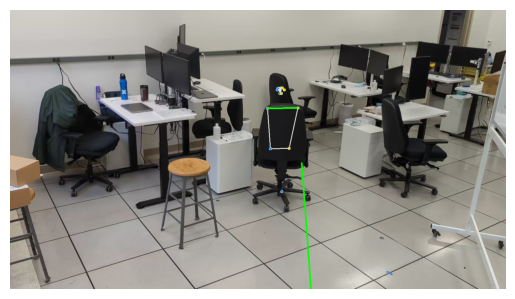

  0%|          | 3/3338 [00:00<08:35,  6.47it/s]

end point: [890.87539673 302.36440945]
end point: [891.10592651 303.53978348]
end point: [893.19406128 305.03323746]


  0%|          | 7/3338 [00:00<05:23, 10.29it/s]

end point: [893.27719116 305.48168564]
end point: [892.68484497 304.9781599 ]
end point: [891.19976807 301.40177536]


  0%|          | 9/3338 [00:01<05:07, 10.83it/s]

end point: [892.07894897 301.8630724 ]
end point: [893.61987305 301.89543915]
end point: [893.59973145 301.96614647]


  0%|          | 13/3338 [00:01<04:40, 11.86it/s]

end point: [893.57693481 301.99367237]
end point: [893.42697144 302.03072548]
end point: [892.69866943 301.98113251]


  0%|          | 15/3338 [00:01<04:59, 11.08it/s]

end point: [892.54110718 298.44295979]
end point: [890.30392456 300.3604002 ]
end point: [890.34457397 305.32049561]


  1%|          | 19/3338 [00:01<04:45, 11.62it/s]

end point: [890.66079712 305.1308012 ]
end point: [890.8644104  302.94894218]
end point: [891.40328979 302.99626923]


  1%|          | 21/3338 [00:02<04:51, 11.36it/s]

end point: [891.45858765 301.12896252]
end point: [891.32455444 300.55424023]
end point: [891.34268188 300.23245239]


  1%|          | 25/3338 [00:02<04:53, 11.27it/s]

end point: [891.12991333 299.97058296]
end point: [891.17514038 299.88952446]
end point: [891.31155396 299.91715336]


  1%|          | 27/3338 [00:02<04:51, 11.37it/s]

end point: [891.51809692 298.78439426]
end point: [891.55563354 301.53881264]
end point: [891.50015259 301.54239178]


  1%|          | 29/3338 [00:02<04:45, 11.59it/s]

end point: [891.73049927 303.39911556]
end point: [891.08377075 302.96063232]
end point: [891.30633545 302.92324448]


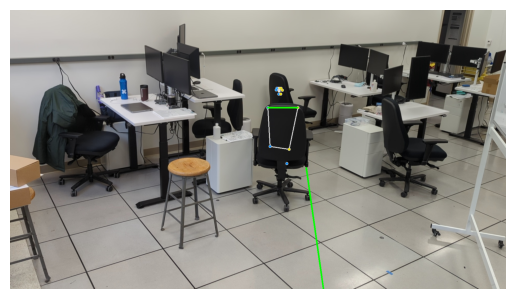

  1%|          | 33/3338 [00:03<05:15, 10.49it/s]

end point: [891.74578857 302.91503048]
end point: [892.09460449 304.9215889 ]
end point: [890.73458862 304.80059338]


  1%|          | 37/3338 [00:03<04:55, 11.15it/s]

end point: [892.93377686 306.36812782]
end point: [891.53512573 306.35625744]
end point: [889.14120483 304.71103764]


  1%|          | 41/3338 [00:03<04:30, 12.20it/s]

end point: [887.37643433 303.15854073]
end point: [888.41372681 303.3101263 ]
end point: [889.31469727 303.25118637]


  1%|▏         | 42/3338 [00:03<05:13, 10.52it/s]


end point: [890.6885376  304.64208126]


KeyboardInterrupt: 

In [19]:
import cv2
import mediapipe as mp
from tqdm import tqdm
from collections import deque
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def body_tracking(frames, frame_folder, to_save=False, to_count=1):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    

    facing_vectors = deque(maxlen=5)
    
    # For static images:
    BG_COLOR = (192, 192, 192) # gray
    with mp_pose.Pose(static_image_mode=False,
                      model_complexity=2,
                      enable_segmentation=True,
                      min_detection_confidence=0.5) as pose:
        
        for count, (name, image) in enumerate(tqdm(frames)):
            
#             if count != 93: continue
            
            # Convert the BGR image to RGB before processing.
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_height, image_width, _ = image.shape
            
            # Resize image
            if True:
                dim = (int(image_width*0.8), int(image_height*0.8))
                image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) 
                
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                facing_vectors.append(body_direction2(landmarks, 19, 11))
            except:
                continue
            
            image_height, image_width, _ = image.shape
            annotated_image = image.copy()
            
            # Draw segmentation on the image.
            # To improve segmentation around boundaries, consider applying a joint
            # bilateral filter to "results.segmentation_mask" with "image".
            if False:
                condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
                bg_image = np.zeros(image.shape, dtype=np.uint8)
                bg_image[:] = BG_COLOR
                annotated_image = np.where(condition, annotated_image, bg_image)
                
            # Draw pose landmarks on the image.
            mp_drawing.draw_landmarks(
                annotated_image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            
            # Save the annoatateed image to a path.
            if False:
                save_path = Path.cwd() / 'frames' / f'{frame_folder}' / 'annotated'
                save_path.mkdir(parents=True, exist_ok=True)
                cv2.imwrite(f'{save_path/f"frame{str(count).zfill(5)}.jpg"}', annotated_image)
            
            # Plot pose world landmarks.
            draw_direction(annotated_image, image_width, image_height, facing_vectors, landmarks, 11, 12) # boddy center
#             draw_direction(annotated_image, image_width, image_height, facing_vectors, landmarks, 19, 21) # left hand
#             draw_direction(annotated_image, image_width, image_height, facing_vectors, landmarks, 20, 22) # right hand
#             draw_direction(annotated_image, image_width, image_height, facing_vectors, landmarks, 11, 19) # right hand
            draw_direction2(annotated_image, image_width, image_height, facing_vectors, landmarks, 20, 12) # right hand
            
            if count % to_count == 0:

                plt.axis('off')                
                if to_save:
                    save_path = Path.cwd() / 'frames' / f'{frame_folder}' / 'body_annotated'
                    save_path.mkdir(parents=True, exist_ok=True)
                    cv2.imwrite(f'{save_path/f"frame{str(count).zfill(5)}.jpg"}', cv2.cvtColor(annotated_image,cv2.COLOR_RGB2BGR))
                else:
                    plt.imshow(annotated_image)
                    plt.show()
                
#                 mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

                x = np.array([results.pose_world_landmarks.landmark[idx].x for idx in range(33)])*100
                z = np.array([results.pose_world_landmarks.landmark[idx].y for idx in range(33)])*100*-1
                y = np.array([results.pose_world_landmarks.landmark[idx].z for idx in range(33)])*100*-1
            
        return facing_vectors
        
print(*body_tracking(frames, FRAME_FOLDER, to_save=False, to_count=30), sep='\n')

# Gesture Classifier

In [ ]:
import csv
import numpy as np
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path

RANDOM_SEED = 42
dataset = Path('/home/hjchris/repo/hand-gesture-recognition-mediapipe/model/keypoint_classifier/keypoint.csv')


X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(3, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [ ]:
import torch
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim    
import gc

class Hand_Classifier(nn.Module):
    def __init__(self, output_class=4):
        super().__init__()
        self.linear1 = nn.Linear(40, 20)
        self.do1 = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(20, 10)
        self.do2 = nn.Dropout(p=0.4)
        self.linear3 = nn.Linear(10, output_class)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.do1(F.relu(self.linear1(x)))
        x = self.do2(F.relu(self.linear2(x)))
        return self.softmax(self.linear3(x))


# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((21 * 2, )),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(20, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

In [ ]:
def label_stats(y_train):
    unique_labels = np.unique(y_train)
    print(f"Unique Labels: {unique_labels}")
    cnts = np.zeros(len(unique_labels))
    for label in unique_labels:
        cnts[label] = sum(y_train == label) / len(y_train)
    print(f"Label Distribution: {cnts}")
    
label_stats(y_train)

In [ ]:
import torch
import torch.optim as optim  
from torch.utils.data import DataLoader
import gc


class Hand_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        'Initialization'
        self.labels = labels
        self.data = data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label

        return self.data[index], self.labels[index]

def train_model(X_train, X_test, y_train, y_test, epochs=1000, batch_size=128, lr=1e-4, log=print):
    
    gc.collect()
    torch.cuda.empty_cache()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    train_dataset = Hand_Dataset(X_train, y_train)
    test_dataset  = Hand_Dataset(X_test, y_test)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

    net       = Hand_Classifier()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    net = net.to(device)
    net.train()
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc  = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            
            labels = labels.type(torch.LongTensor).to(device)
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc  += torch.sum(outputs.argmax(dim=1) == labels) / len(labels)

        if (epoch+1)%5 == 0: log(f'Epoch {epoch + 1:3d} - Batch: {i + 1:2d} - Loss: {running_loss / (i+1):.4f} - Acc: {running_acc/(i+1):.4f}')

    print('Finished Training.')
    
    net.eval()
    running_loss = 0.0
    running_acc  = 0.0
    
    for i, (inputs, labels) in enumerate(test_loader):
        
            labels = labels.type(torch.LongTensor).to(device)
            inputs = inputs.to(device)

            outputs = net(inputs)
            loss    = criterion(outputs, labels)
            
            running_loss += loss.item()
            running_acc  += torch.sum(outputs.argmax(dim=1) == labels) / len(labels)
            
    log(f"Eval | Loss: {running_loss/(i+1):.4f} - Acc: {running_acc/(i+1):.4f}")

train_model(X_train, X_test, y_train, y_test, epochs=250, lr=1e-3)

## Classifier

In [ ]:
# cv.waitKey(10)

def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 ~ 9
        number = key - 48
    if key == 110:  # n
        mode = 0
    if key == 107:  # k
        mode = 1
    if key == 104:  # h
        mode = 2
    return number, mode

def logging_csv(number, mode, landmark_list, point_history_list):
    if mode == 0:
        pass
    if mode == 1 and (0 <= number <= 9):
        csv_path = 'model/keypoint_classifier/keypoint.csv'
        Path(csv_path).mkdir(parents=True, exist_ok=True)
        
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *landmark_list])
    if mode == 2 and (0 <= number <= 9):
        csv_path = 'model/point_history_classifier/point_history.csv'
        Path(csv_path).mkdir(parents=True, exist_ok=True)
        
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *point_history_list])
    return


# print(select_mode(51,1))

import torch
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim    
import gc

class Hand_Classifier(nn.Module):
    def __init__(self, output_class=4):
        super(Hand_Classifier, self).__init__()
        
        self.linear1 = nn.Linear(40, 20)
        self.do1 = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(20, 10)
        self.do2 = nn.Dropout(p=0.4)
        self.linear3 = nn.Linear(10, output_class)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
#         x = self.do1(F.relu(self.linear1(x)))
#         x = self.do2(F.relu(self.linear2(x)))
        return self.softmax(self.linear3(x))

import torch
from pathlib import Path
import torch.optim as optim  
import gc


class Hand_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        'Initialization'
        self.labels = labels
        self.data = data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label

        return self.data[index], self.labels[index]

# Evaluate with Hand Classifier

In [ ]:
import cv2 as cv
import itertools
import copy
import numpy as np

def calc_bounding_rect(image, landmarks):
    '''
    bounding box calculation. 
    
    Output: bottom left and upper right coordinates.
    '''
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]
        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv.boundingRect(landmark_array)

    return [x, y, x + w, y + h]


def draw_bounding_rect(use_brect, image, brect):
    '''
    Draw bounding box (outer rectangle) on image.
    '''
    if use_brect:
        # Outer rectangle
        cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 0, 0), 1)

    return image


def pre_process_landmark(landmark_list):
    '''
    Flatten and noramlize the numpy array. 
    Convert to relative coordinates, change it to one-dimnesional, and normalize it
    '''
    
    # Convert to relative coordinates
    temp_landmark_list = np.array(copy.deepcopy(landmark_list))
    temp_landmark_list[:, 0] -= temp_landmark_list[0][0]
    temp_landmark_list[:, 1] -= temp_landmark_list[0][1]

    # Convert to a one-dimensional list
    temp_landmark_list = temp_landmark_list.flatten()

    # Normalization
    max_value = max(np.absolute(temp_landmark_list))

    return list(temp_landmark_list / max_value)

def calc_landmark_list(image, landmarks):
    '''
    Convert landmark to list form. The coordinates are in pixels.
    
    Intput: landmarks
    Output: [[lm0], [lm1], [lm2], [lm3]...]
    '''
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

def pre_process_point_history(image, point_history):
    '''
    
    Input: one point.
    Output:
    '''
    image_width, image_height = image.shape[1], image.shape[0]
    temp_point_history = copy.deepcopy(point_history)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, point in enumerate(temp_point_history):
        if index == 0:
            base_x, base_y = point[0], point[1]

        temp_point_history[index][0] = (temp_point_history[index][0] - base_x) / image_width
        temp_point_history[index][1] = (temp_point_history[index][1] - base_y) / image_height

    # Convert to a one-dimensional list
#     temp_point_history = temp_point_history.flatten()
    temp_point_history = list(itertools.chain.from_iterable(temp_point_history))

    return temp_point_history


def roatate_landmark(landmark_list):
    
    landmark_list_temp = np.array(copy.deepcopy(landmark_list))
    length = len(landmark_list_temp)
    coords = list(zip(landmark_list_temp[range(0, length, 2)], landmark_list_temp[range(1, length, 2)]))
    ba = np.array([0, 1])
    bc = np.array(landmark_list[34:36])
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    for i in range(0, length, 2):
        px, py = landmark_list_temp[i], landmark_list_temp[i+1]
        landmark_list_temp[i] = 0+math.cos(angle)*(px-0)-math.sin(angle)*(py-0)
        landmark_list_temp[i+1] = 0+math.sin(angle)*(px-0)+math.cos(angle)*(py - 0)
    
#     coords = [(0+math.cos(angle)*(px-0)-math.sin(angle)*(py-0), 0+math.sin(angle)*(px-0)+math.cos(angle)*(py - 0)) for (px, py) in coords]
    return landmark_list_temp


def draw_info_text(image, brect, handedness, hand_sign_text,
                   finger_gesture_text):
    cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22),
                 (0, 0, 0), -1)

    info_text = handedness.classification[0].label[0:]
    if hand_sign_text != "":
        info_text = info_text + ':' + hand_sign_text
    cv.putText(image, info_text, (brect[0] + 5, brect[1] - 4),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv.LINE_AA)

#     if finger_gesture_text != "":
#         cv.putText(image, "Finger Gesture:" + finger_gesture_text, (10, 60),
#                    cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 4, cv.LINE_AA)
#         cv.putText(image, "Finger Gesture:" + finger_gesture_text, (10, 60),
#                    cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2,
#                    cv.LINE_AA)

    return image

## Run

In [ ]:
import mediapipe as mp
from time import sleep
from tqdm import tqdm
import progressbar
import copy
import csv
from collections import Counter
from collections import deque
import math

# widgets = [' [', progressbar.Timer(format= 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('*'),' (', progressbar.ETA(), ') ',]
# bar = progressbar.ProgressBar(widgets=widgets).start()


def get_locations(frames, frame_folder, to_plot=False, to_save=False,
                  max_num_hands=2, use_static_image_mode=False, min_detection_confidence=0.7, min_tracking_confidence=0.5):
    '''
    Run MediaPipe Hands and plot 3d hands world landmarks.
    world_locations: real-world 3D coordinates in meters with the origin at the hand’s approximate geometric center.
    '''
    valid_frames    = []
    frame_names     = []
    skipped_frames  = []
    finger_gesture_history = deque(maxlen=16)
    all_index = [item for item in range(21)]
    locations       = {hand_no :{idx:{'x':[],'y':[],'z':[]} for idx in all_index} for hand_no in range(max_num_hands)}
    world_locations = {hand_no :{idx:{'x':[],'y':[],'z':[]} for idx in all_index} for hand_no in range(max_num_hands)}
    
    # Labels for classification
    with open(f'/home/hjchris/repo/hand-gesture-recognition-mediapipe/'+
              f'model/point_history_classifier/point_history_classifier_label.csv',encoding='utf-8-sig') as f:
        point_history_classifier_labels = csv.reader(f)
        point_history_classifier_labels = [row[0] for row in point_history_classifier_labels]
       
    with open(f'/home/hjchris/repo/hand-gesture-recognition-mediapipe/'+
              f'model/keypoint_classifier/keypoint_classifier_label.csv',encoding='utf-8-sig') as f:
        keypoint_classifier_labels = csv.reader(f)
        keypoint_classifier_labels = [row[0] for row in keypoint_classifier_labels]
    
    # Coordinate history #################################################################
    history_length = 16
    hand_gesture_ids = []
    hand_gesture_index = []
    point_history = deque(maxlen=history_length)
    mode = 1
    number = 2
    
    
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    
    net = Hand_Classifier(4)
    net.load_state_dict(torch.load(Path(f"/home/hjchris/research/22vr-kl/pytorch_model/hand_classifier.pth")))
    net.eval()
    
    with mp_hands.Hands(static_image_mode=use_static_image_mode, 
                        max_num_hands=max_num_hands, 
                        min_detection_confidence=min_detection_confidence,
                        min_tracking_confidence=min_tracking_confidence,) as hands:
        
        for count, (name, img) in enumerate(tqdm(frames)):
            
            # Flip the image(frame)
            img = cv2.flip(img, 1)

            # Convert BGR image to RGB image
            imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Process the RGB image
            imgRGB.flags.writeable = False
            results = hands.process(imgRGB)
            imgRGB.flags.writeable = True
            
            # If hands are present in image(frame)
            if not results.multi_handedness: 
                skipped_frames.append(name)
                for key, subsets in locations.items():
                    for idx, values in subsets.items():
                        for coord in ['x', 'y', 'z']: 
                            world_locations[key][idx][coord].append(0)
                            locations[key][idx][coord].append(0)
                continue
           
            # Log the valid outputs
            frame_names.append(name)
            image_height, image_width, _ = img.shape
            annotated_image = imgRGB.copy()
            
            # Read normalized hand landmarks
            '''
            multi_hand_landmarks: simulated x, y, and z of each index.
            multi_handedness: index, score, and label.
            '''
            for hand_no, (hand_landmarks, handedness, hand_world_landmarks) in enumerate(zip(results.multi_hand_landmarks, 
                                                                                             results.multi_handedness, 
                                                                                             results.multi_hand_world_landmarks)):

                # Draw hand world landmarks.
                for idx in all_index:
                    #mp_drawing.plot_landmarks(hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
#                     print(mp_hands.HandLandmark(idx))
                    world_locations[hand_no][idx]['x'].append(hand_world_landmarks.landmark[mp_hands.HandLandmark(idx).value].x)
                    world_locations[hand_no][idx]['y'].append(hand_world_landmarks.landmark[mp_hands.HandLandmark(idx).value].y)
                    world_locations[hand_no][idx]['z'].append(hand_world_landmarks.landmark[mp_hands.HandLandmark(idx).value].z)
                    
                # calculate bounding box
                brect = calc_bounding_rect(annotated_image, hand_landmarks)

                # Conversion to relative coordinates / normalized coordinates
                landmark_list = calc_landmark_list(annotated_image, hand_landmarks) # transform the datapoint to list format.
                pre_processed_landmark_list = pre_process_landmark(landmark_list)   # preprocess: normalize the datapoint.
                pre_processed_landmark_list = roatate_landmark(pre_processed_landmark_list)
                pre_processed_point_history_list = pre_process_point_history(annotated_image, point_history)  #

                
                # Figure gesture classification
                hand_sign_id = net(torch.Tensor([pre_processed_landmark_list[2:]]))
                hand_sign_id = int(hand_sign_id.argmax(dim=1)[0])
                hand_gesture_ids.append(hand_sign_id)
                hand_gesture_index.append(pre_processed_landmark_list)
                # logging_csv(number, mode, pre_processed_landmark_list, pre_processed_point_history_list)

                # Finger gesture classification
                finger_gesture_id = 0
#                 point_history_len = len(pre_processed_point_history_list)
#                 if point_history_len == (history_length * 2):
#                     finger_gesture_id = point_history_classifier(pre_processed_point_history_list)
                finger_gesture_history.append(finger_gesture_id)
                most_common_fg_id = Counter(finger_gesture_history).most_common()

        
                # Drawing part
                annotated_image = draw_info_text(annotated_image,
                                                 brect,
                                                 handedness,
                                                 keypoint_classifier_labels[hand_sign_id],
                                                 point_history_classifier_labels[most_common_fg_id[0][0]],)
                mp_drawing.draw_landmarks(annotated_image,
                                          hand_landmarks,
                                          mp_hands.HAND_CONNECTIONS,
                                          mp_drawing_styles.get_default_hand_landmarks_style(),
                                          mp_drawing_styles.get_default_hand_connections_style())
                
                annotated_image = draw_bounding_rect(True, annotated_image, brect)
                
                if hand_sign_id == 1:
                    print(name)
#                 for idx in all_index:
#                     print(mp_hands.HandLandmark(idx))
#                     #mp_drawing.plot_landmarks(hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
#                     print('x', hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].x * image_width)
#                     print('y', hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].y * image_height)
#                     print('z', hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].z * image_width)
#                     print()
#                     print('x', hand_world_landmarks.landmark[mp_hands.HandLandmark(idx).value].x)
#                     print('y', hand_world_landmarks.landmark[mp_hands.HandLandmark(idx).value].y)
#                     print('z', hand_world_landmarks.landmark[mp_hands.HandLandmark(idx).value].z)
                    plt.figure(figsize=(16,8))
                    plt.imshow(annotated_image)
                    plt.axis('off')
                    plt.title(name)
                    plt.show()


            # flip back the annotated image and save
            if to_save == True:
                annotated_image = cv2.flip(annotated_image, 1)
                save_path = Path.cwd() / 'frames' / f'{frame_folder}' / 'cropped_annotated'
                save_path.mkdir(parents=True, exist_ok=True)
                cv2.imwrite(f'{save_path/f"frame{str(count).zfill(5)}.jpg"}', annotated_image)

    # print all skipped frames
    if skipped_frames:
        print(f"Skipped {len(skipped_frames)} frames:\n{'-'*19}")
        print(*skipped_frames, sep='\n')
        
    return world_locations, frame_names, hand_gesture_ids, hand_gesture_index

world_locations, frame_names, hand_gesture_ids, hand_gesture_index = get_locations(frames, FRAME_FOLDER, 
                                                                                   to_plot=False, to_save=False)

In [ ]:
# 0:OPEN, 1:CLOSE, 2:POINTER
def label_stats(y_train):
    unique_labels = np.unique(y_train)
    print(f"Unique Labels: {unique_labels}")
    cnts = np.zeros(len(unique_labels))
    for label in unique_labels:
        cnts[label] = sum(y_train == label) / len(y_train)
    print(f"Label Distribution: {cnts}")
    
label_stats(hand_gesture_ids)

In [ ]:
def roatate_landmark(landmark_list):
    
    landmark_list_temp = np.array(copy.deepcopy(landmark_list))
    length = len(landmark_list_temp)
    coords = list(zip(landmark_list_temp[range(0, length, 2)], landmark_list_temp[range(1, length, 2)]))
    ba = np.array([0, 1])
    bc = np.array(landmark_list[34:36])
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    for i in range(0, length, 2):
        px, py = landmark_list_temp[i], landmark_list_temp[i+1]
        landmark_list_temp[i] = 0+math.cos(angle)*(px-0)-math.sin(angle)*(py-0)
        landmark_list_temp[i+1] = 0+math.sin(angle)*(px-0)+math.cos(angle)*(py - 0)
    
#     coords = [(0+math.cos(angle)*(px-0)-math.sin(angle)*(py-0), 0+math.sin(angle)*(px-0)+math.cos(angle)*(py - 0)) for (px, py) in coords]
    return landmark_list_temp

In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt


line_sets = [(0,1), (1,2), (2,3), (3,4), (0,5), (5,6), 
             (6,7), (7,8), (5,9), (9,13), (13,17), (0,17), 
             (9, 10), (10, 11), (11, 12), (13,14), (14, 15), 
             (15, 16), (17,18), (18,19), (19,20)]


for cnt, sets in enumerate(hand_gesture_index):
    points = np.array(sets)
    length = len(points)
    coords = list(zip(points[range(0, length, 2)], points[range(1, length, 2)]))
    
    ba = np.array([0, 1])
    bc = np.array(coords[17])

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    coords = [(0 + math.cos(angle) * (px - 0) - math.sin(angle) * (py - 0), 0 + math.sin(angle) * (px - 0) + math.cos(angle) * (py - 0))for (px, py) in coords]
    
    for (first, second) in line_sets:
        plt.plot([coords[first][0], coords[second][0]], [coords[first][1], coords[second][1]], 'bo-')
    plt.show()
    if cnt > 50: break

# Result Evaluation

## Plot Locations

In [ ]:
import mediapipe as mp
from time import sleep
from tqdm import tqdm
import progressbar

# widgets = [' [', progressbar.Timer(format= 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('*'),' (', progressbar.ETA(), ') ',]
# bar = progressbar.ProgressBar(widgets=widgets).start()

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
# help(mp_hands.Hands)

def plot_locations(frames, selected_index = [item for item in range(21)], to_plot=False):
    '''
    Run MediaPipe Hands and plot 3d hands world landmarks.
    '''
    valid_frames   = []
    frame_names    = []
    skipped_frames = []
    hand_orient  = {0:[],1:[]}
    locations = {'Left':{idx:{'x':[],'y':[],'z':[]} for idx in selected_index},
                 'Right':{idx:{'x':[],'y':[],'z':[]} for idx in selected_index}} 
    
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7) as hands:
        for count, (name, img) in enumerate(tqdm(frames)):
           
            img = img[100:500, 50:1000]
            
            # Flip the image(frame)
            img = cv2.flip(img, 1)

            # Convert BGR image to RGB image
            imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Process the RGB image
            results = hands.process(imgRGB)
            
            # If hands are present in image(frame)
#             print(f'{name} Handedness:\n', results.multi_handedness)
            
            hand_map = {hand_info.classification[0].index:hand_info.classification[0].label for hand_info in results.multi_handedness}

            # if there are only one hand
            if len(hand_map) < 2: 
                skipped_frames.append(name)
                for key, subsets in locations.items():
                    for idx, values in subsets.items():
                        locations[key][idx]['x'].append(0)
                        locations[key][idx]['y'].append(0)
                        locations[key][idx]['z'].append(0)
                        hand_orient[0].append('X')
                        hand_orient[1].append('X')
                continue
            
            # Log the valid outputs
            frame_names.append(name)
            valid_frames.append(count)
            hand_orient[0].append(hand_map[0])
            hand_orient[1].append(hand_map[1])
            
            if not results.multi_hand_landmarks:
                continue
            image_height, image_width, _ = img.shape
            annotated_image = img.copy()

            # Read the normalized hand landmarks.
            for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
                for idx in selected_index:
                    print(hand_no, hand_map[hand_no])
                    print(f'{idx} | {mp_hands.HandLandmark(idx).name}') 
                    print(mp_hands.HandLandmark(idx).value)
                    print(f'x: {hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].x * image_width}')
                    print(f'y: {hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].y * image_height}')
                    print(f'z: {hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].z * image_width}')

                    locations[hand_map[hand_no]][idx]['x'].append(hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].x * image_width)
                    locations[hand_map[hand_no]][idx]['y'].append(hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].y * image_height)
                    locations[hand_map[hand_no]][idx]['z'].append(hand_landmarks.landmark[mp_hands.HandLandmark(idx).value].z * image_width)

            # Draw hands on frames
            for hand_landmarks in results.multi_hand_landmarks:
                print('hand_landmarks:', hand_landmarks)
                print(f'Index finger tip coordinates: (',
                      f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
                      f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
                     )
                mp_drawing.draw_landmarks(
                  annotated_image,
                  hand_landmarks,
                  mp_hands.HAND_CONNECTIONS,
                  mp_drawing_styles.get_default_hand_landmarks_style(),
                  mp_drawing_styles.get_default_hand_connections_style())

            # plot annotated images
            if to_plot:
                plt.imshow(annotated_image)
                plt.axis('off')
                plt.show()

            if count > 0: break
            
plot_locations(frames, to_plot=False)

In [ ]:
import numpy as np


def find_mean(locations, hand='Left'):
    time_frame = {coord:np.zeros(len(valid_frames)) for coord in ['x', 'y', 'z']}
    for idx, subsets in locations[hand].items():
        for coord, values in subsets.items():
            time_frame[coord] += np.array(values)[valid_frames]
    for idx, values in time_frame.items():
        values /= len(locations[hand])
        
    finals = np.sqrt(time_frame['x']**2 + time_frame['y']**2 + time_frame['z']**2)
    return finals
    
left_means  = find_mean(locations, 'Left')
right_means = find_mean(locations, 'Right')

last_val = 0

In [ ]:
import numpy as np

def calcaute_movements(locations, valid_frames, hand='Left', selected_index = [item for item in range(16)]):
    '''
    calcaulate the euclidean distance for each index.
    '''
    movements = {idx:{} for idx in selected_index}
    valid_indexes = {}
    
    # Calculate the movements in different axis.
    for idx, subsets in locations[hand].items():
        if idx in selected_index:
            for coord, current in subsets.items():
                past     = np.array([0] + current)
                current  = np.array(current + [0])

                valid = current == 0
                valid += past == 0

                movements[idx][coord] = (current-past)[1:-1]
                valid_indexes[idx] = (~valid).nonzero()[0][1:-1]

    # Calculate the euclidean distance 
    index_distance = {}
    for idx, subsets in movements.items(): # for each index
        distance = sum([np.array(values)**2 for coord, values in subsets.items()]) # calculate x^2 + y^2 + z^2
        index_distance[idx] = np.sqrt(distance)
    
    return index_distance, valid_indexes

In [ ]:
import matplotlib.pyplot as plt

distances, valid_index = calcaute_movements(locations, valid_frames)
for key, value in distances.items():
    if key in [0]:
        fig = plt.figure(figsize=(20,8))
        moving = y > 100
        x = valid_index[key]
        y = value[x]
        plt.plot(x, y, 'o', markersize=6, label=key)
        plt.grid()
        plt.xticks(range(0, 900, 30), range(30))
        plt.legend()
        plt.yscale('log')
        plt.show()
        
        
distances, valid_index = calcaute_movements(locations, valid_frames, hand='Right')
for key, value in distances.items():
    if key in [0]:
        fig = plt.figure(figsize=(20,8))
        moving = y > 100
        x = valid_index[key]
        y = value[x]
        plt.plot(x, y, 'o', markersize=6, label=key)
        plt.grid()
#         plt.xticks(range(0, 900, 30), range(30))
        plt.legend()
        plt.yscale('log')
        plt.show()

## XYZ

In [ ]:
def draw_xyz(locations, x, hand='Left', index=0):
    coordinates = ['x', 'y', 'z']
    ys = [np.array(locations[hand][index][coord]) for coord in coordinates]
    
    fig = plt.figure(figsize=(20,5))
    for i, y in enumerate(ys):
        plt.plot(x, y[x], 'o', markersize=4, label=coordinates[i])
    plt.grid()
    plt.title(f"{hand} Hand, Index {index}")
    plt.xticks(range(0, 900, 30), range(30))
    plt.legend()
    # plt.yscale('log')
    plt.show()

# for idx in [3,4,7,8]:
#     draw_xyz(locations, valid_frames, index=idx)

## Relative Movements

In [ ]:
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 
          'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']*2




def related_movement(locations, hand='Left', first_index=4, second_index=8):
    
    valid_index = np.array(locations[hand][first_index]['x']) == 0
    x = np.array(locations[hand][first_index]['x']) - np.array(locations[hand][second_index]['x'])
    y = np.array(locations[hand][first_index]['y']) - np.array(locations[hand][second_index]['y'])
    z = np.array(locations[hand][first_index]['z']) - np.array(locations[hand][second_index]['z'])
        
    return (~valid_index).nonzero()[0], np.sqrt(x**2+y**2+z**2)


SIZE = 25
FIRST_INDEX = 4
SECOND_INDEX = 0

fig = plt.figure(figsize=(SIZE,7))
for hand in ['Right', 'Left']:
    x, y = related_movement(locations, hand=hand, first_index=FIRST_INDEX, second_index=8)
#     x = range(230,400)
    plt.plot(x, y[x], 'o', markersize=4, label=hand)

plt.grid(axis='both', which='both')
plt.legend(fontsize=SIZE)
plt.title(f"Index {FIRST_INDEX}-{8} in pixels", size=SIZE)
# plt.ylim(0,30)
# plt.xticks(range(0, 900, 30), range(30))
plt.xticks(range(0, 900, 15), range(0, 900, 15))
plt.xlim(0, 900)
# plt.yscale('log')
plt.yticks(size=SIZE)
plt.show()


# fig = plt.figure(figsize=(SIZE,15))
fig, ax = plt.subplots(figsize=(SIZE,15))

# for idx, hand in enumerate(['Right', 'Left']):
#     for si in range(0, 21):
#         if si != 4:
#             x, y = related_movement(world_locations, hand=hand, first_index=FIRST_INDEX, second_index=si)
#             plt.plot(x, y[x]*100, 'o', markersize=2, color=plt.get_cmap(colors[si])(idx*0.5+0.4), label=f"{hand} {FIRST_INDEX}-{si}")

for idx, hand in enumerate(['Right', 'Left']):
    for si in range(0, 21):
        if si != 4:
            x, y = related_movement(world_locations, hand=hand, first_index=FIRST_INDEX, second_index=si)
            plt.plot(x, y[x]*100, 'o', markersize=2, color=plt.get_cmap(colors[si])(idx*0.5+0.4), label=f"{hand} {FIRST_INDEX}-{si}")
    break
    
# plt.yscale('log')
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=2)
ax.tick_params(which='minor', length=2)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xticks(np.arange(0, 900, 30), range(30))
ax.set_xticks(np.arange(0, 900, 3), minor = True)
plt.grid(axis='both', which='both')
plt.grid(axis='both', which='minor', linestyle='--')
plt.legend(fontsize=15)
plt.title(f"Index in centimeters", size=SIZE)

# plt.ylim(0,17)
# plt.xticks(range(0, 900, 30), range(30))
# plt.xticks(range(0, 900, 15), range(0, 900, 15))
plt.yticks(size=SIZE)
plt.xlim(0, 900)
plt.savefig('test1.pdf')